# <div style='padding:25px;background-color:maroon;color:white;border-radius:4px;font-size:100%;text-align: center'>Banking Data Analysis<br></div>

# <div style='padding:7px;background-color:Maroon;color:white;border-radius:2px;font-size:100%;text-align: center'>Regression Modeling<br></div>

## <span style="color:Aqua;">Importing libraries from Python</span>

In [1]:
import pandas as pd
pd.options.display.max_columns = 50
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)

import numpy as np
import os

import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.color': 'black',  # Change font color
    'axes.labelcolor': 'black',  # Change axis label color
    'xtick.color': 'black',  # Change x-tick color
    'ytick.color': 'black',  # Change y-tick color
    'font.weight': 'bold',  # Change font weight
    'axes.titleweight': 'bold',  # Change title weight
    'axes.labelweight': 'bold',# Change label weight
})

import scipy.stats as stats
from scipy.stats import pearsonr,kstest, norm, skew,kurtosis, boxcox

from category_encoders import TargetEncoder

from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score,root_mean_squared_error,max_error
import xgboost as xg

import pickle
import time



In [2]:
color_good = '\033[32m'   # Dark Green for near-zero skew
color_okay = '\033[92m'   # Light Green for slightly positive or slightly negative skew
color_bad = '\033[91m'    # Maroon for significant skew
color_neutral = '\033[0m' # Reset color

def univar_num(df, col):
    plt.figure(figsize=(16, 8))
    df = df.dropna(subset=[col])


    mean=df[col].mean()
    median=df[col].median()
    mode=df[col].mode()[0]
    sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})
    plt.subplot(2, 3, 1)
    sns.histplot(data=df, x=col, kde=True, bins=50,color='maroon',fill=True)
    plt.title(f'Histogram for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean')
    plt.axvline(median, color='black', label='Median')
    plt.axvline(mode, color='darkgreen', label='Mode')
    sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)

    
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df, x=col, color='lightgrey',legend=True)
    plt.xticks(rotation=45)
    plt.title(f'Box Plot for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean')
    plt.axvline(median, color='black', label='Median')
    plt.axvline(mode, color='darkgreen', label='Mode')
    plt.legend()
    plt.tight_layout()

    
    plt.subplot(2, 3, 3)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.gca().get_lines()[1].set_color('maroon')
    plt.gca().get_lines()[0].set_color('darkgreen')
    plt.title(f'QQ Plot for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

    plt.tight_layout()
    
    plt.tight_layout()
    plt.show()

In [3]:
def kurtosis_color(kurt_val):
    if -1 <= kurt_val <= 1:
        kurt_color = color_good  # Dark Green for near-zero kurtosis (good)
    elif 1 < kurt_val <= 3 or -3 <= kurt_val < -1:
        kurt_color = color_okay  # Yellow for moderate kurtosis
    else:  # kurt_val > 3 or kurt_val < -3
        kurt_color = color_bad  # Maroon for extreme kurtosis
    return kurt_color

def skewness_color(skew_val):
    if -0.5 <= skew_val <= 0.5:
        color = color_good  # Dark Green for near-zero skew
    elif 0 < skew_val <= 0.5 or -0.5 < skew_val < 0:
        color = color_okay  # Light Green for slightly positive or slightly negative skew
    else:  # skew_val > 0.5 or skew_val < -0.5
        color = color_bad  # Maroon for significant skew
    return color

In [4]:

# Defining a function to perform Box-Cox
def boxcox_transform(x):
    transformed_data,lmbda = boxcox(x + np.spacing(1))
    return transformed_data,lmbda

method_functions =  {
    'log': lambda x: np.log(x + np.spacing(1)),
    'square': np.sqrt,
    'rec': lambda x: np.where(x != 0, 1 / x, np.spacing(1)),
    'sig': lambda x: 1 / (1 + np.exp(-x)),
    'cube': lambda x: np.power(x, 3),
    'exp':lambda x: x**(1/5),
    'boxcox': boxcox_transform,
        }

def skewness_checker(df, column, method,pkl_path=None):
    transformed_columns = {}
    transformation_params = {}

    for method_name, func in method_functions.items():
        for col in column:

            new_column = f'{col}_{method_name}'
            if method_name == 'boxcox':
                transformed_values, lmbda = func(df[col])
                transformation_params[new_column] = lmbda 
            else:
                transformed_values = func(df[col])
            transformed_columns[new_column] = transformed_values
    normalized_df = pd.DataFrame(transformed_columns)
    if not os.path.exists(pkl_path):
        os.makedirs(pkl_path)
    file_path = os.path.join(pkl_path,'transformation_params.pkl')
    with open(file_path, 'wb') as f:
        pickle.dump(transformation_params, f)
        
    return normalized_df, transformation_params

def process_column(col):
    univar_num(df, col) 
    skew_val = df[col].skew()
    kurt = df[col].kurtosis()
    
    kurt_color = kurtosis_color(kurt)
    color = skewness_color(skew_val)
    
    skewed_col.append(col)
    
    print(f"\n\n{color}Skew for {col} is {skew_val:.4f}{color_neutral}")
    print(f"{color}Kurtosis for {col} is {kurt:.4f}{color_neutral}\n\n")


## <span style="color:Aqua;">Reading model dataset:</span>

In [5]:
df = pd.read_feather('transfered_data.feather')
df.sample(3)

months_as_customer policy_bind_date policy_state  policy_deductable  \
408                 275       1991-11-20           OH               2000   
431                 270       2003-08-23           OH                500   
370                 396       1992-10-11           IN               1000   

    insured_sex insured_education_level insured_occupation insured_hobbies  \
408        MALE                 Masters    exec-managerial         camping   
431      FEMALE                     PhD    priv-house-serv        yachting   
370        MALE             High School    protective-serv        exercise   

    insured_relationship incident_date             incident_type  \
408            unmarried    2015-01-06  Single Vehicle Collision   
431        not-in-family    2015-02-24   Multi-vehicle Collision   
370       other-relative    2015-01-30   Multi-vehicle Collision   

      collision_type incident_severity authorities_contacted incident_state  \
408   Rear Collision      Minor Damage                  Fire             OH   
431   Side Collision        Total Loss                 Other             VA   
370  Front Collision      Major Damage                 Other             NC   

    incident_city incident_hour_of_the_day number_of_vehicles_involved  \
408     Riverwood                       17                           1   
431      Columbus                       23                           3   
370      Columbus                       22                           3   

    property_damage bodily_injuries witnesses police_report_available  \
408             YES               1         3                     YES   
431              NO               0         0                     YES   
370             YES               2         1                      NO   

     auto_make auto_year fraud_reported  age_boxcox  \
408  Chevrolet      2001              N      4.2527   
431       Saab      2005              N      4.4089   
370       Saab      1995              N      4.7266   

     policy_annual_premium_boxcox  total_claim_amount_boxcox  \
408                     1193.7419                 87969.6520   
431                     1190.6594                112444.1976   
370                     1370.2511                108496.1233   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  
408             -25280               -25280            61680.0056  
431               5632                    0           103943.4971  
370             -32768                20480            80237.5794

In [6]:
# df = pd.read_feather('clustered.feather')
# df.sample(3)

In [7]:
df['insurance_age'] = pd.to_numeric((df.incident_date.dt.year - df.policy_bind_date.dt.year),errors='raise',downcast='integer')
df['vehicle_age'] = pd.to_numeric((df.incident_date.dt.year - df.auto_year.astype(int)),errors='raise',downcast='integer')

In [8]:
ordinal = ['insured_education_level','incident_severity',]

nominal = ['policy_state','insured_sex','insured_occupation','insured_hobbies','insured_relationship','incident_type',
           'collision_type','authorities_contacted','incident_state','incident_city','property_damage',
           'police_report_available','auto_make','fraud_reported']

discrete = ['months_as_customer','incident_hour_of_the_day','number_of_vehicles_involved','auto_year'
            ,'witnesses','bodily_injuries']
continuous = ['age_boxcox','injury_claim_cube','total_claim_amount_boxcox','property_claim_cube','vehicle_claim_boxcox','insurance_age',
              'vehicle_age','policy_deductable','policy_annual_premium_boxcox']

date = ['policy_bind_date','incident_date']

print(len(ordinal + nominal + discrete +continuous + date))
print(len(df.columns))


33
33


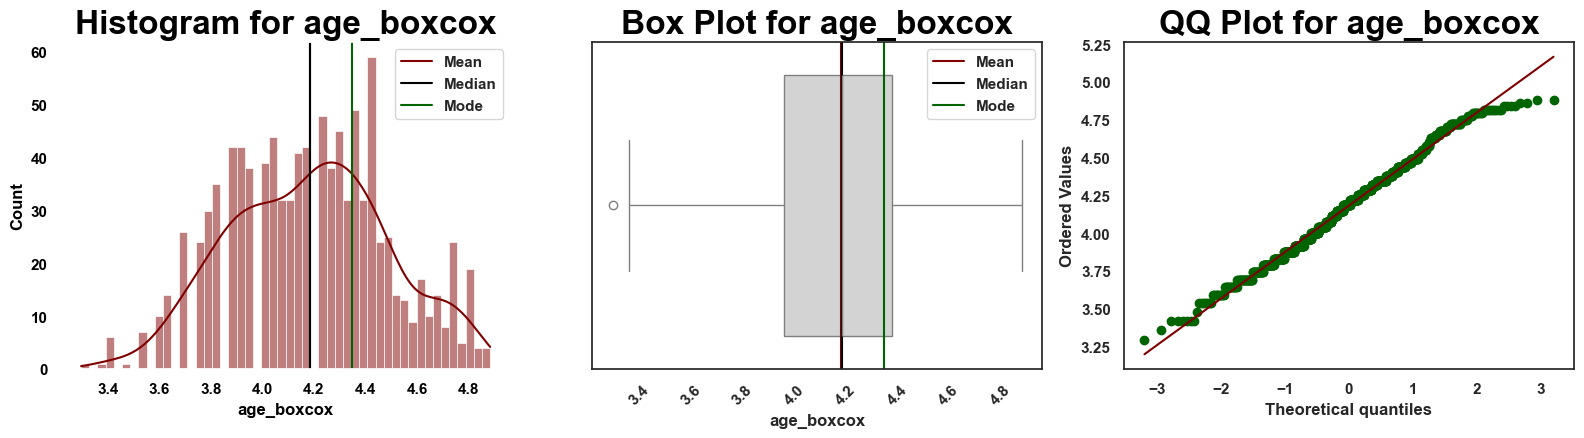



Skew for age_boxcox is -0.0029
Kurtosis for age_boxcox is -0.4858




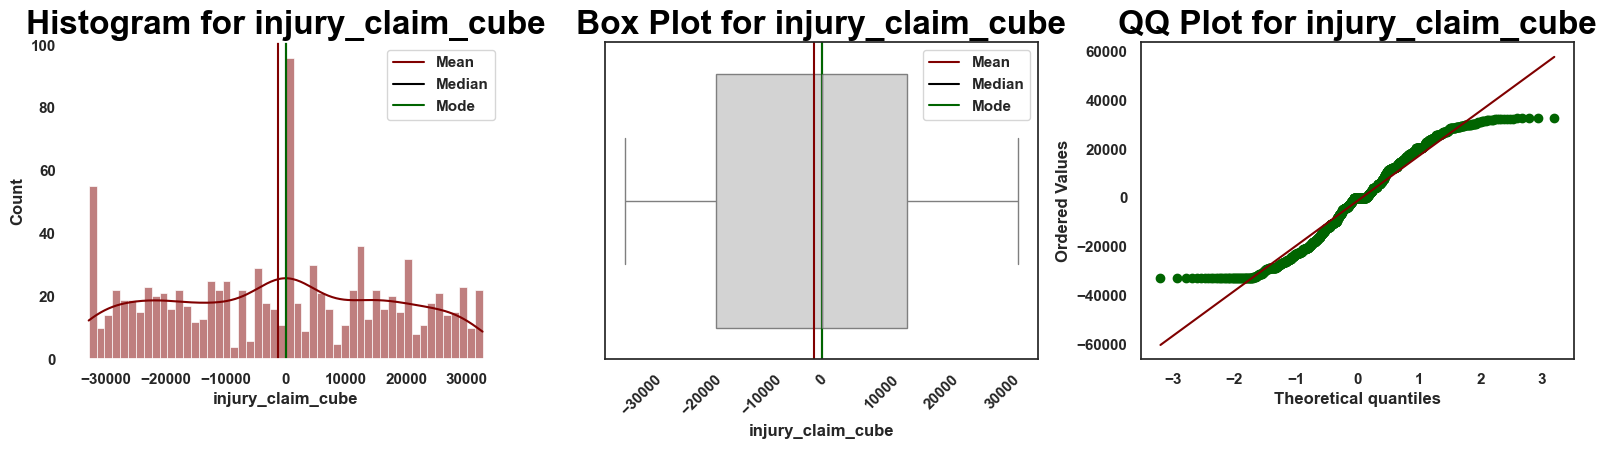



Skew for injury_claim_cube is 0.0054
Kurtosis for injury_claim_cube is -1.0722




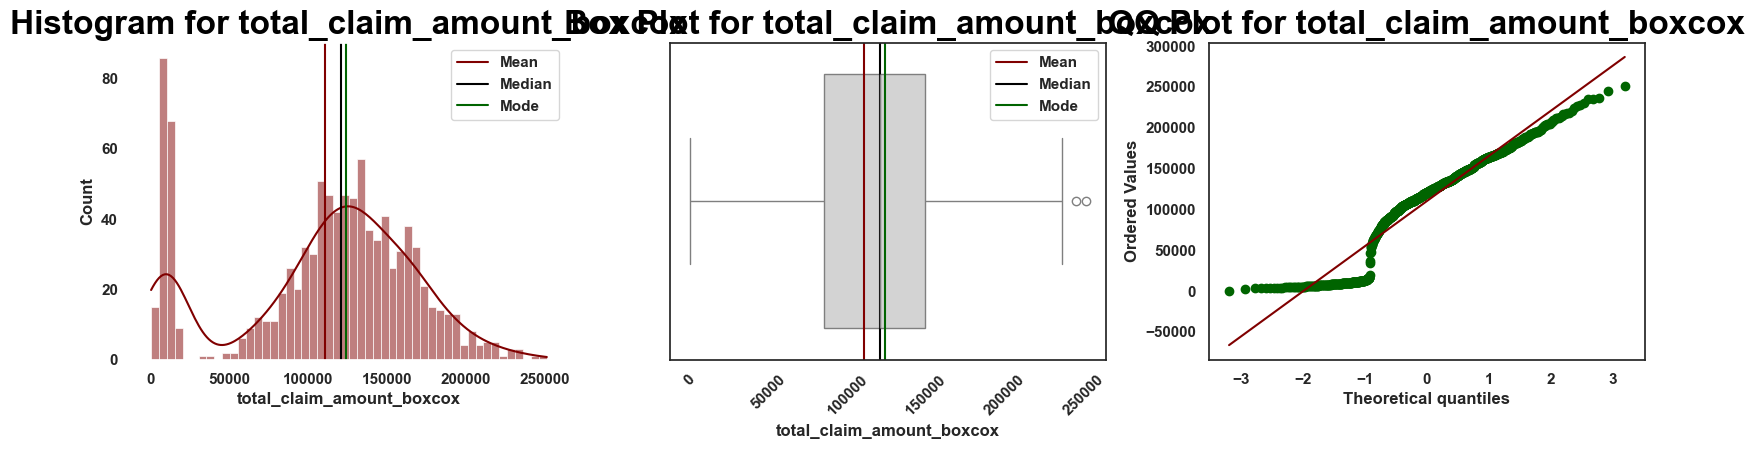



Skew for total_claim_amount_boxcox is -0.5104
Kurtosis for total_claim_amount_boxcox is -0.4878




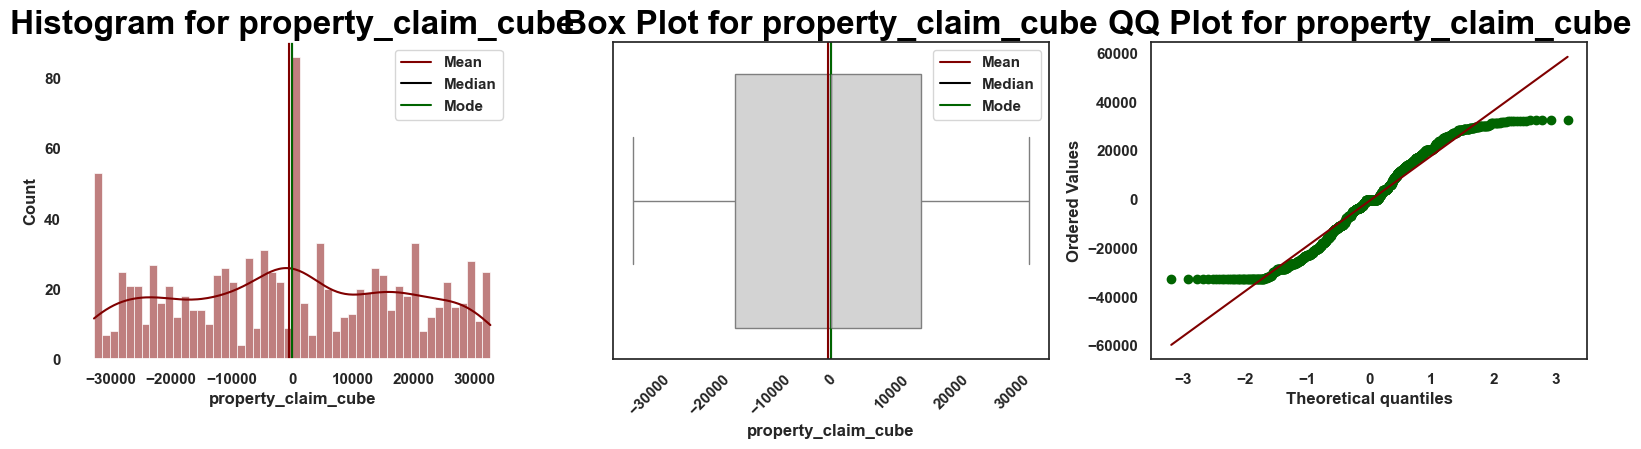



Skew for property_claim_cube is -0.0187
Kurtosis for property_claim_cube is -1.0615




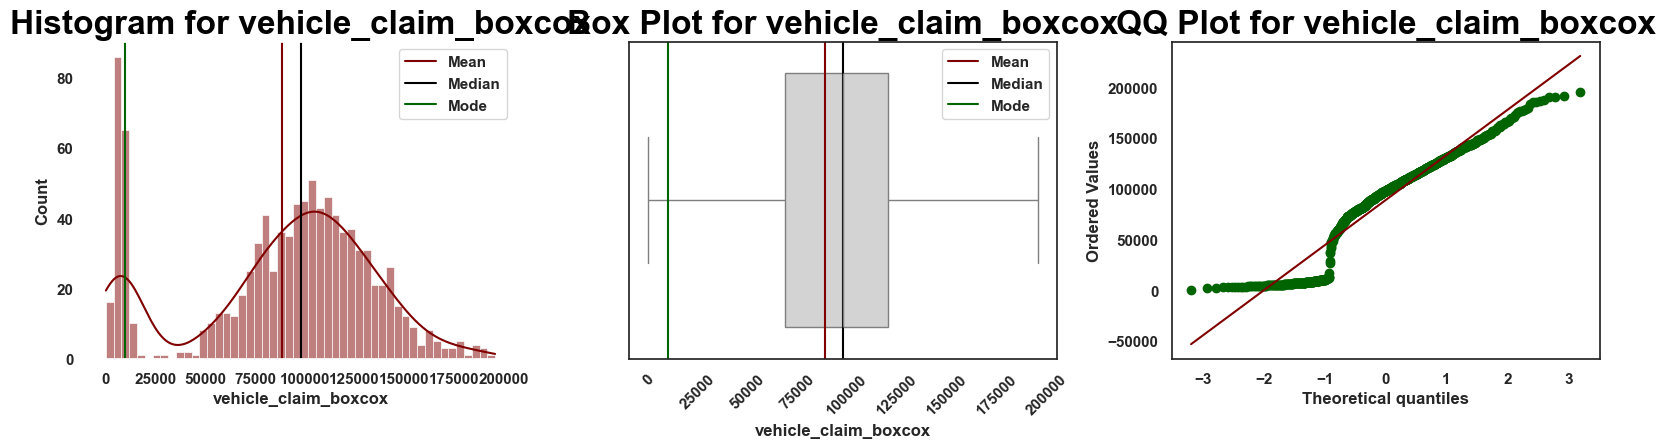



Skew for vehicle_claim_boxcox is -0.5228
Kurtosis for vehicle_claim_boxcox is -0.4890




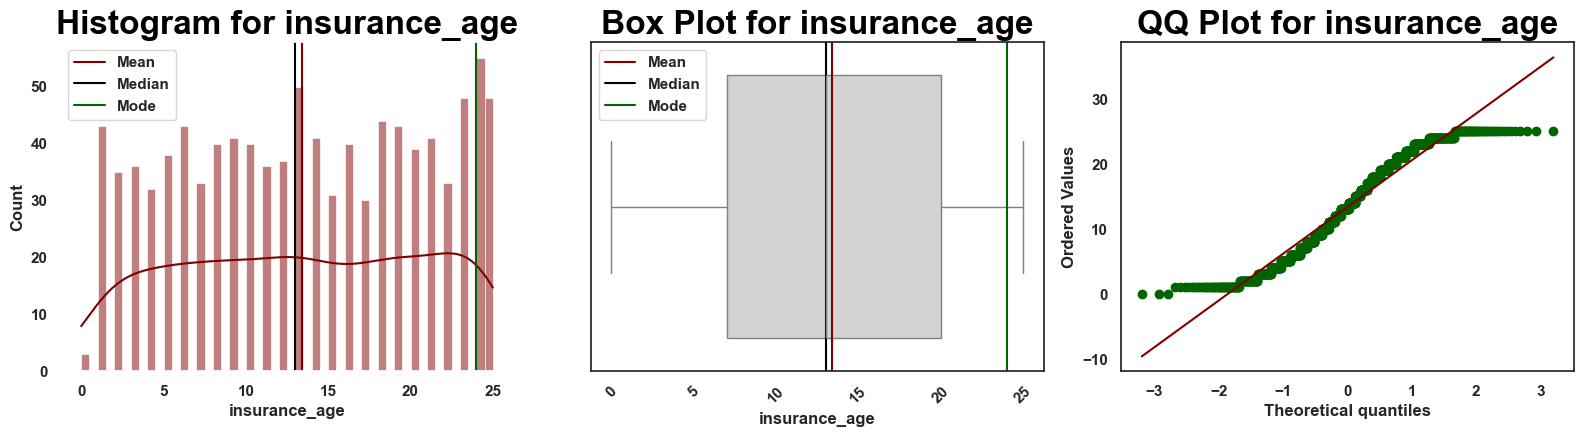



Skew for insurance_age is -0.0525
Kurtosis for insurance_age is -1.2124




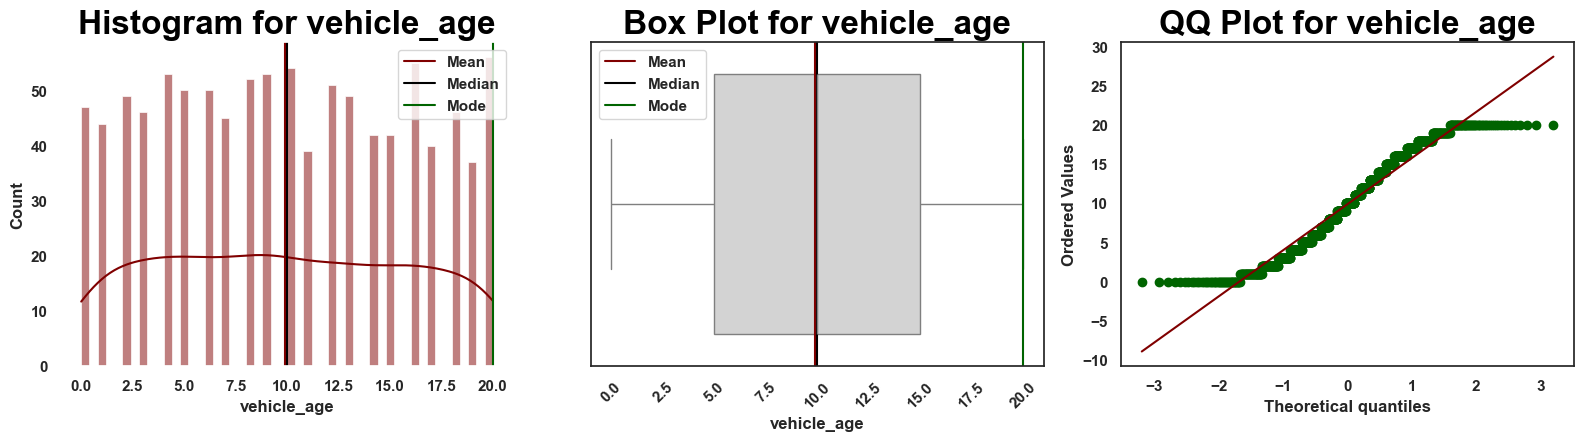



Skew for vehicle_age is 0.0483
Kurtosis for vehicle_age is -1.1719




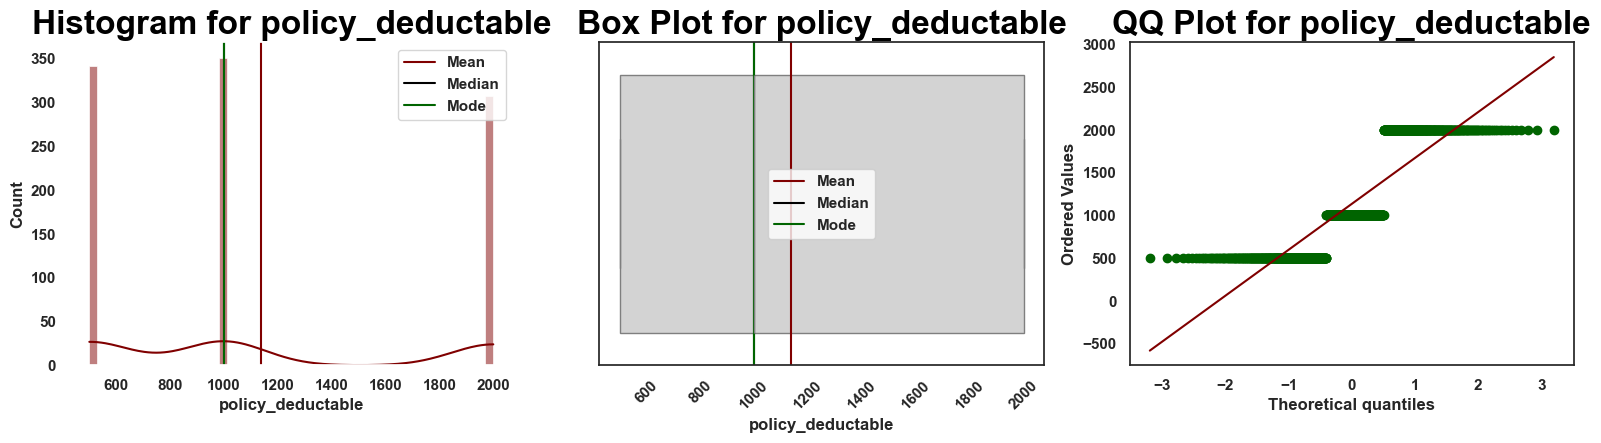



Skew for policy_deductable is 0.4779
Kurtosis for policy_deductable is -1.3769




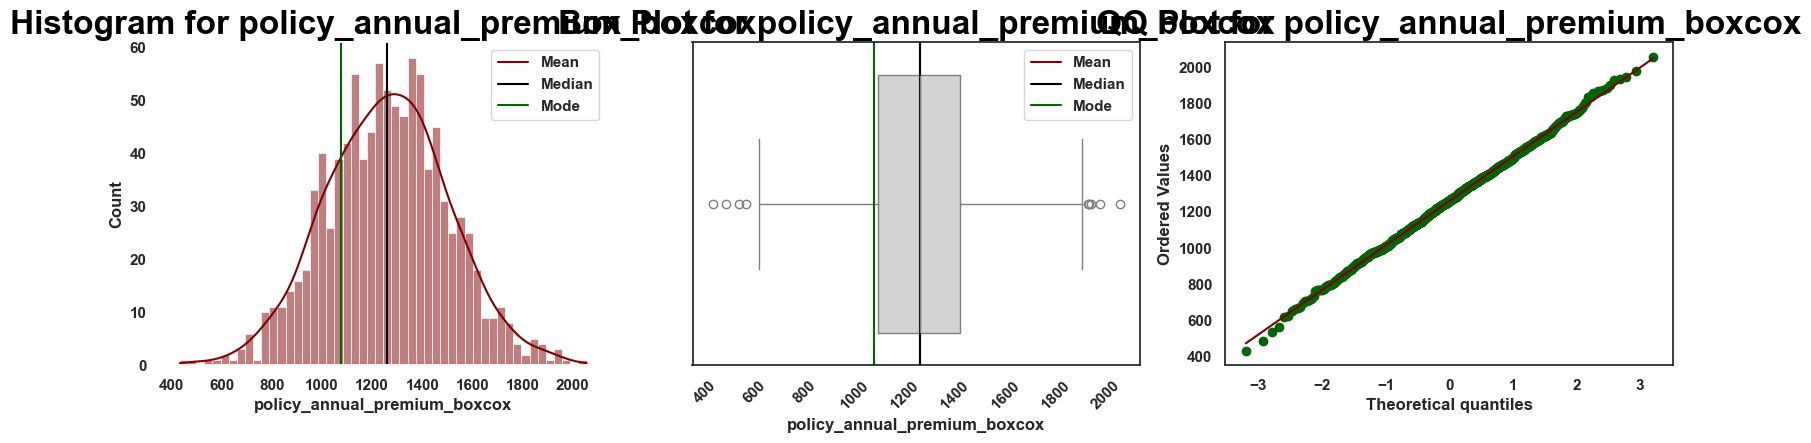



Skew for policy_annual_premium_boxcox is 0.0048
Kurtosis for policy_annual_premium_boxcox is 0.0738




In [9]:
skewed_col = []

_ = list(map(process_column, continuous))

In [10]:
def outlier(df, column,iqr_fact=1.5):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    upper_threshold = df[column].quantile(0.75) + (iqr_fact*iqr)
    lower_threshold = df[column].quantile(0.25) - (iqr_fact*iqr)
    df[column] = df[column].clip(lower_threshold, upper_threshold)
    return df

In [11]:
for i in continuous:
    outlier(df, i,iqr_fact=1.5)
    

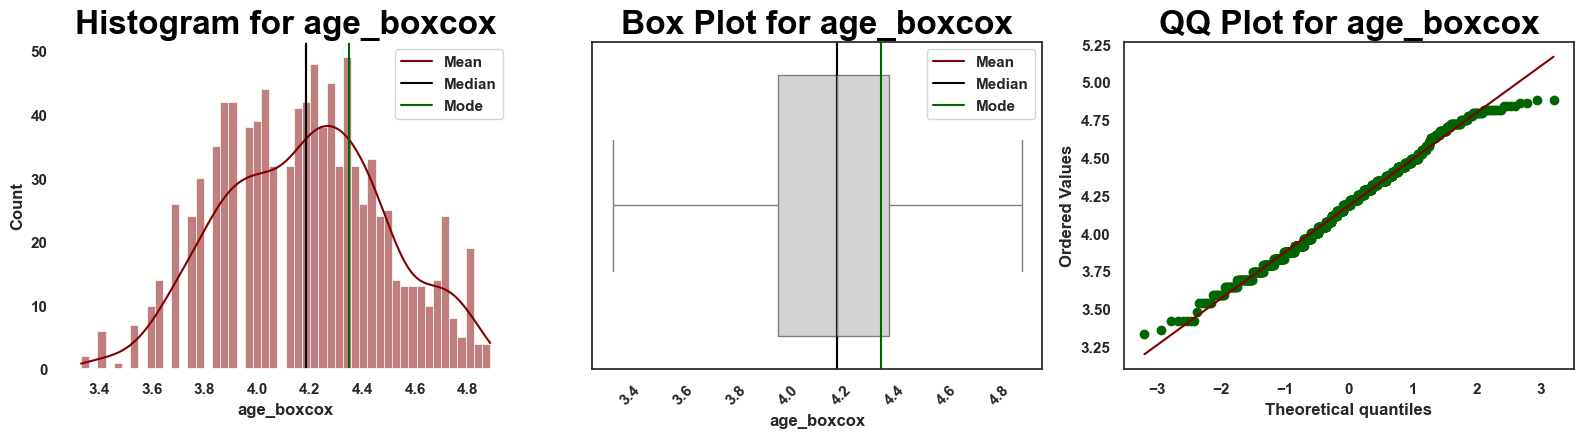



Skew for age_boxcox is -0.0004
Kurtosis for age_boxcox is -0.4931




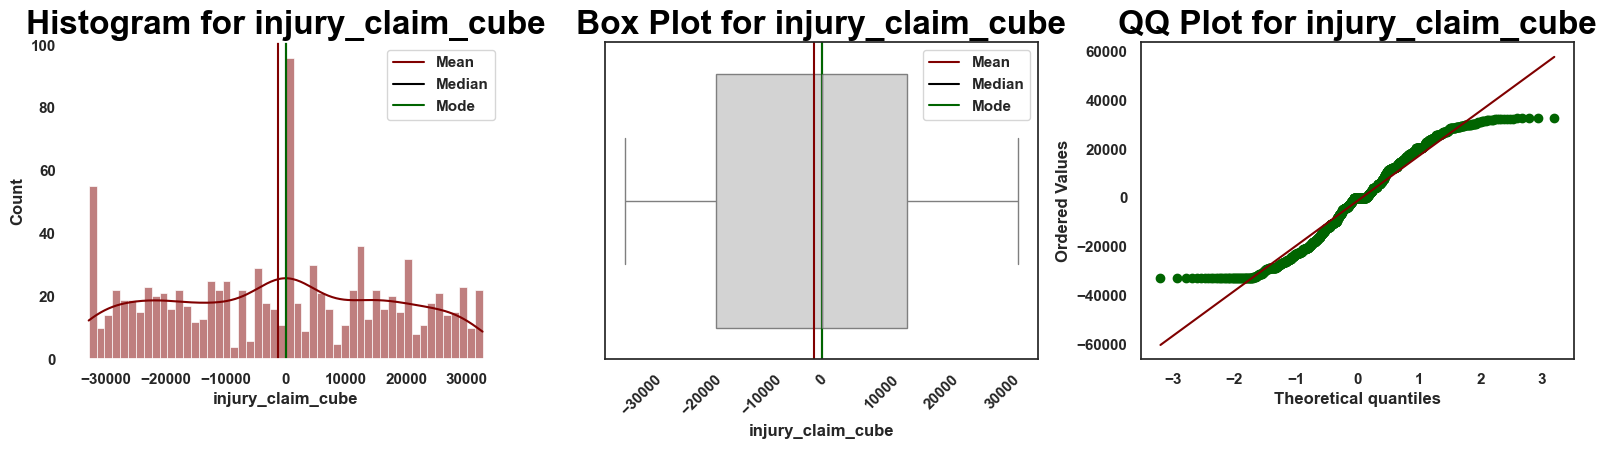



Skew for injury_claim_cube is 0.0054
Kurtosis for injury_claim_cube is -1.0722




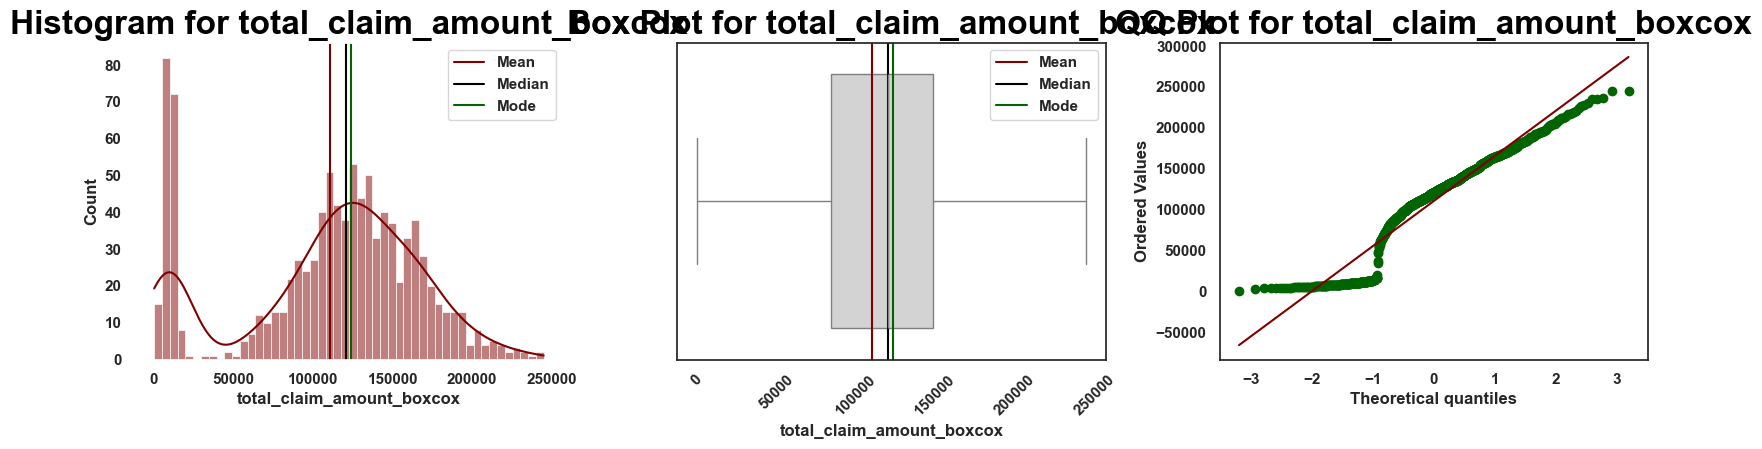



Skew for total_claim_amount_boxcox is -0.5125
Kurtosis for total_claim_amount_boxcox is -0.4916




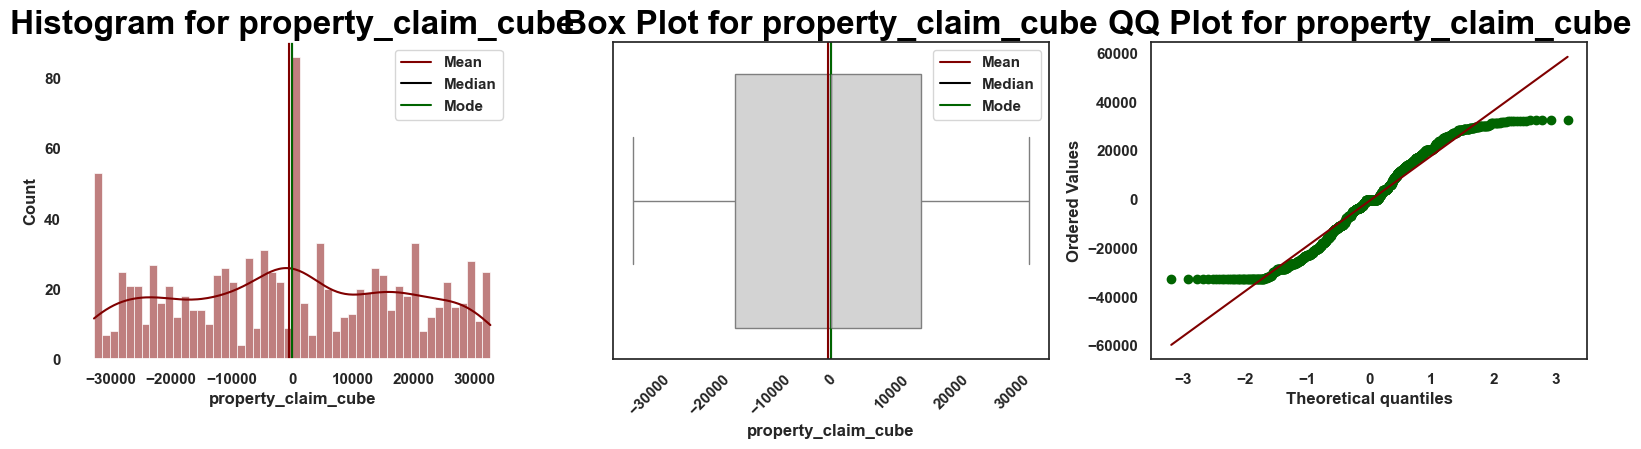



Skew for property_claim_cube is -0.0187
Kurtosis for property_claim_cube is -1.0615




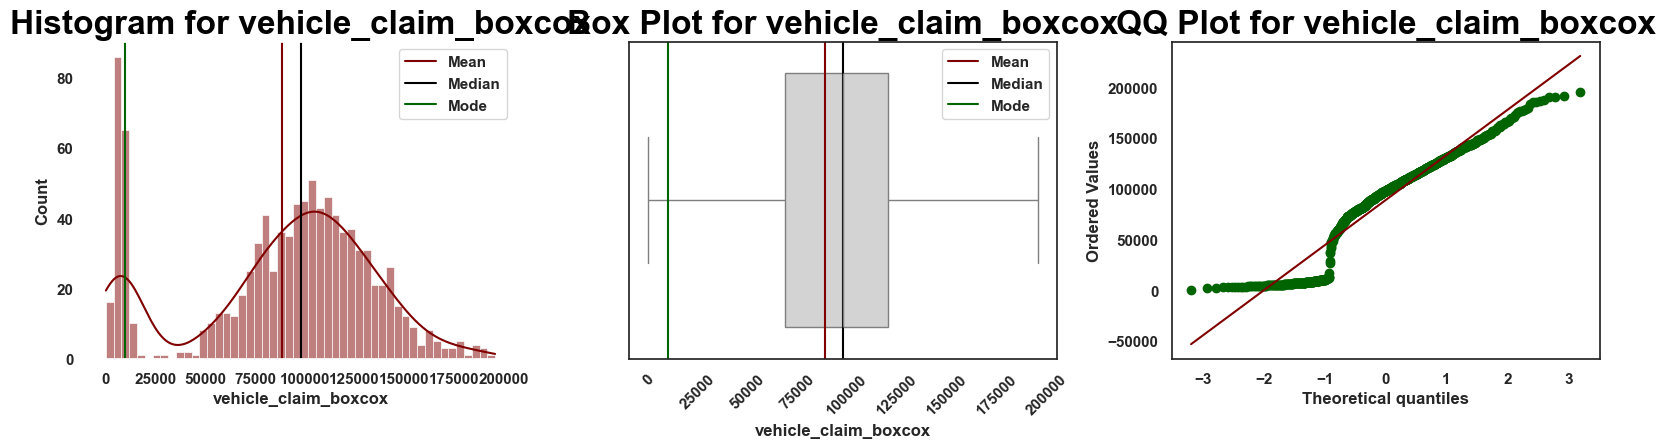



Skew for vehicle_claim_boxcox is -0.5228
Kurtosis for vehicle_claim_boxcox is -0.4890




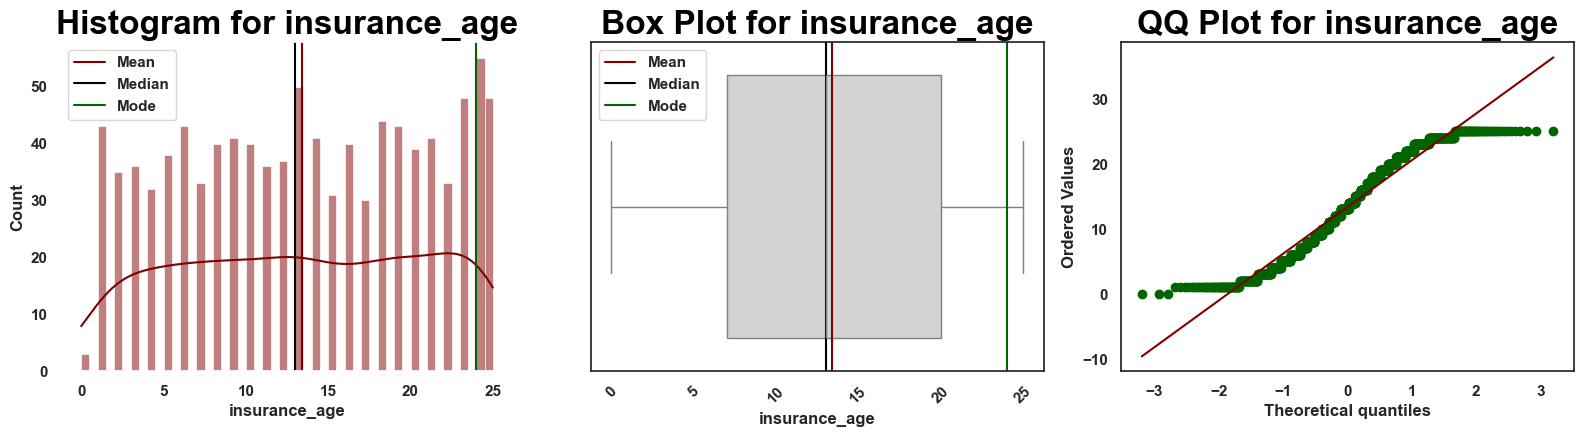



Skew for insurance_age is -0.0525
Kurtosis for insurance_age is -1.2124




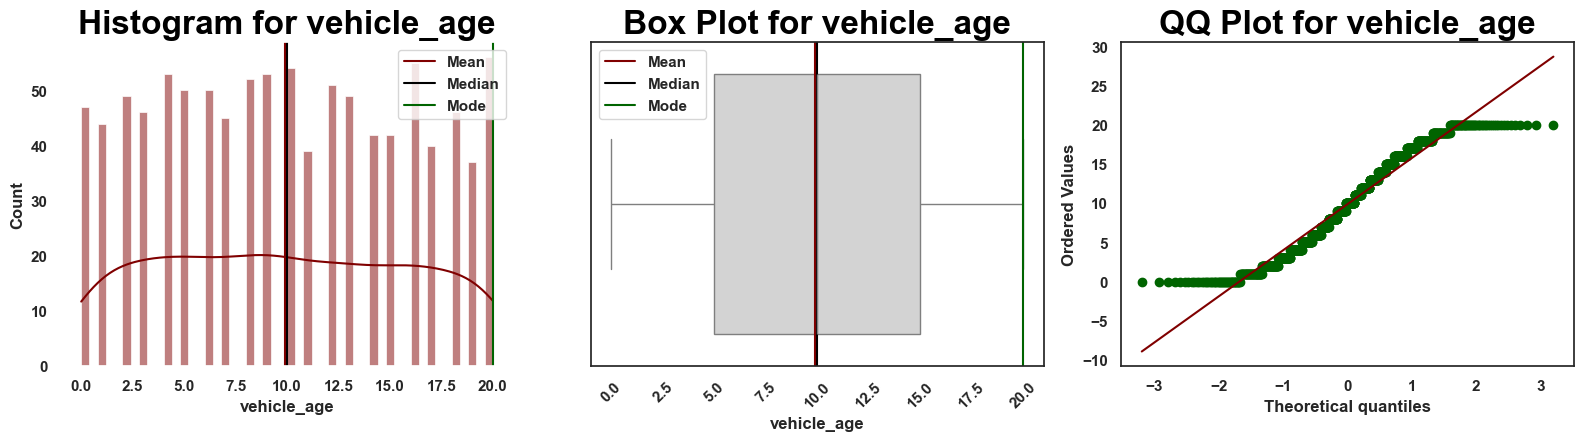



Skew for vehicle_age is 0.0483
Kurtosis for vehicle_age is -1.1719




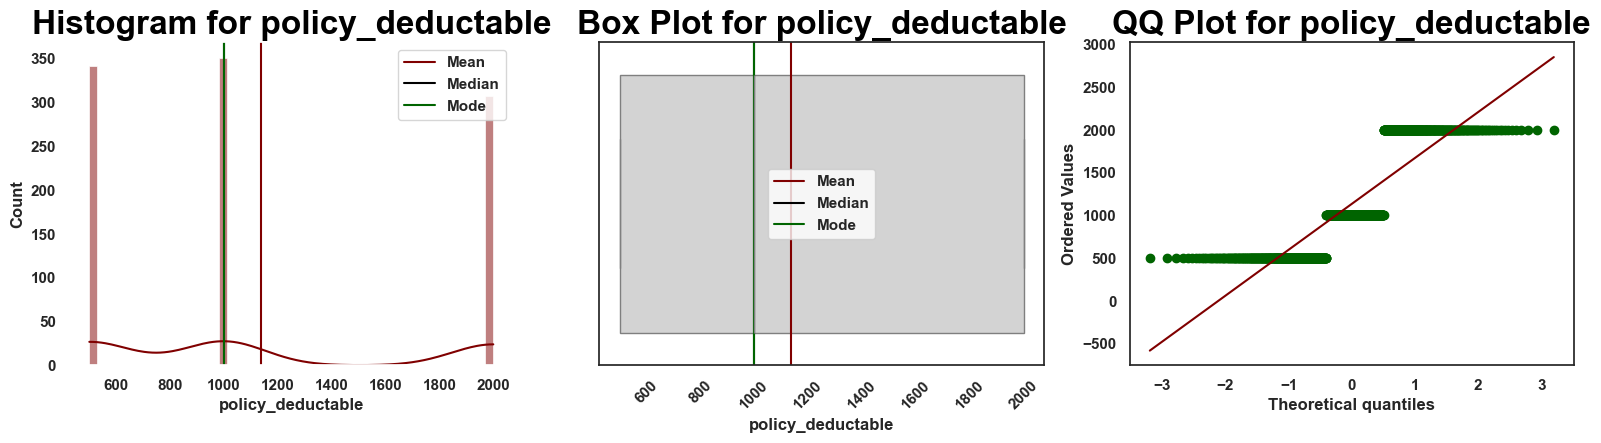



Skew for policy_deductable is 0.4779
Kurtosis for policy_deductable is -1.3769




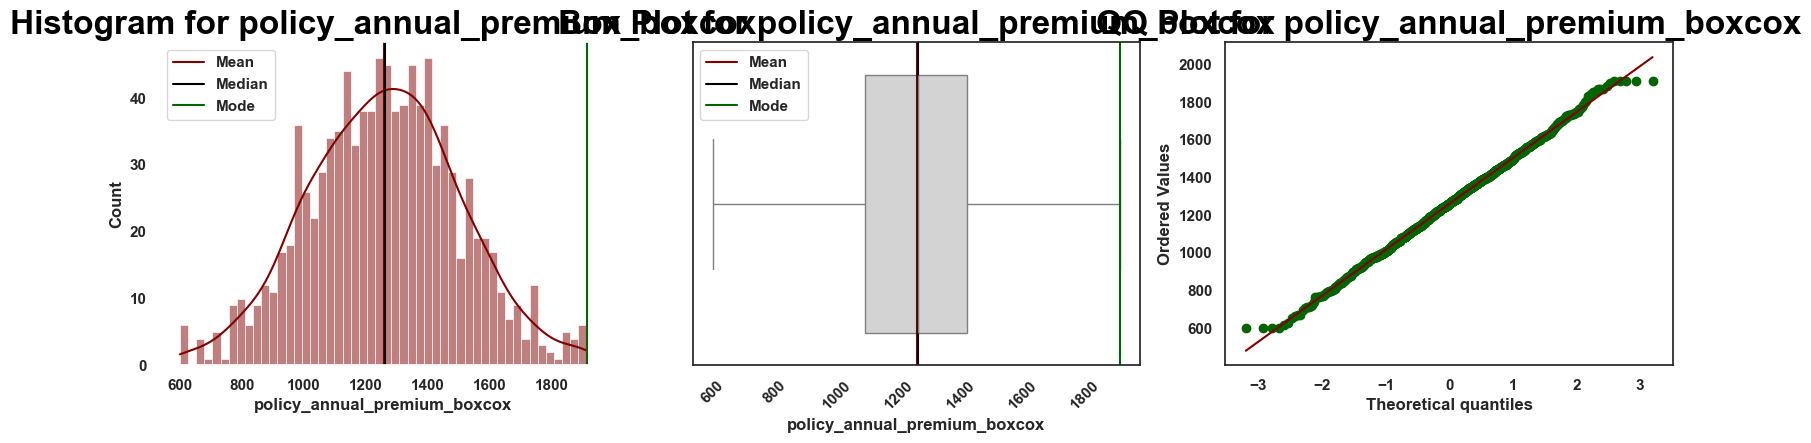



Skew for policy_annual_premium_boxcox is 0.0163
Kurtosis for policy_annual_premium_boxcox is -0.1041




In [12]:
skewed_col = []

_ = list(map(process_column, continuous))

In [13]:
encoder = TargetEncoder()

In [14]:
for i in nominal:
    df[i] = encoder.fit_transform(df[i],df['policy_annual_premium_boxcox'])
    df[i] = pd.to_numeric(df[i],errors='raise',downcast='integer')
    print(i,'\n',df[i].min(), '--', df[i].max())

policy_state 
 1256.4721074653764 -- 1264.0550613282498
insured_sex 
 1250.8981527163003 -- 1270.4027313444292
insured_occupation 
 1219.0101069211182 -- 1310.1585893998197
insured_hobbies 
 1180.2909816718095 -- 1308.7609934709553
insured_relationship 
 1251.4785950816279 -- 1274.4198723409093
incident_type 
 1237.0583583464488 -- 1277.4809297514462
collision_type 
 1250.1644005612245 -- 1273.9123695088988
authorities_contacted 
 1244.0246613781917 -- 1276.5757638330176
incident_state 
 1233.3986920851662 -- 1296.919923345424
incident_city 
 1238.8211382510315 -- 1307.6092255167312
property_damage 
 1259.821953543553 -- 1259.98503610473
police_report_available 
 1257.6687132044638 -- 1263.8947722035277
auto_make 
 1200.8641118206 -- 1323.3975870631389
fraud_reported 
 1253.885122422616 -- 1261.9112183040434


In [15]:
df.sample(3)

months_as_customer policy_bind_date  policy_state  policy_deductable  \
153                 431       1994-11-11     1264.0551               1000   
525                  41       2006-03-28     1256.4721               1000   
680                 222       2008-06-17     1259.0123               2000   

     insured_sex insured_education_level  insured_occupation  insured_hobbies  \
153    1250.8982                 Masters           1269.4790        1180.2910   
525    1250.8982                      JD           1262.8020        1300.3776   
680    1270.4027                      MD           1226.9587        1278.9566   

     insured_relationship incident_date  incident_type  collision_type  \
153             1274.4199    2015-01-08      1246.2443       1259.7932   
525             1274.4199    2015-02-28      1266.1437       1252.4021   
680             1255.4897    2015-02-22      1277.4809       1250.1644   

    incident_severity  authorities_contacted  incident_state  incident_city  \
153        Total Loss              1276.5758       1278.0321      1238.8211   
525    Trivial Damage              1244.0247       1244.4832      1307.6092   
680        Total Loss              1244.0247       1257.3898      1266.2217   

    incident_hour_of_the_day number_of_vehicles_involved  property_damage  \
153                       13                           3        1259.8220   
525                       12                           1        1259.9850   
680                       20                           1        1259.9850   

    bodily_injuries witnesses  police_report_available  auto_make auto_year  \
153               2         3                1263.8948  1228.1333      1997   
525               1         1                1263.8948  1313.5720      1997   
680               2         2                1263.8948  1264.1668      2001   

     fraud_reported  age_boxcox  policy_annual_premium_boxcox  \
153       1261.9112      4.6535                     1376.1554   
525       1261.9112      3.6929                     1387.0603   
680       1261.9112      4.1851                     1160.9799   

     total_claim_amount_boxcox  injury_claim_cube  property_claim_cube  \
153                132321.3751              31936                31936   
525                 12256.7888             -20792                30272   
680                126133.8474                  0                    0   

     vehicle_claim_boxcox  insurance_age  vehicle_age  
153            98110.9575             21           18  
525            10293.3767              9           18  
680           110517.4072              7           14

In [16]:
for i in ordinal+discrete:
    grouping = df.groupby(i,observed=False)['policy_annual_premium_boxcox'].mean().rank(method='first').reset_index().sort_values('policy_annual_premium_boxcox')
    en_list = dict(zip(grouping[i], grouping['policy_annual_premium_boxcox'].astype(int)))
    df[i] = pd.to_numeric(df[i].map(en_list),errors='raise',downcast='integer')
    print(f'{i} -- {en_list}')
    

insured_education_level -- {'Masters': 1, 'JD': 2, 'College': 3, 'Associate': 4, 'PhD': 5, 'MD': 6, 'High School': 7}
incident_severity -- {'Trivial Damage': 1, 'Major Damage': 2, 'Minor Damage': 3, 'Total Loss': 4}
months_as_customer -- {410: 1, 419: 2, 303: 3, 59: 4, 389: 5, 17: 6, 213: 7, 77: 8, 98: 9, 35: 10, 237: 11, 324: 12, 425: 13, 157: 14, 167: 15, 90: 16, 153: 17, 415: 18, 72: 19, 315: 20, 10: 21, 385: 22, 227: 23, 236: 24, 467: 25, 62: 26, 472: 27, 202: 28, 291: 29, 399: 30, 465: 31, 109: 32, 468: 33, 317: 34, 308: 35, 270: 36, 66: 37, 463: 38, 5: 39, 81: 40, 131: 41, 356: 42, 149: 43, 412: 44, 162: 45, 288: 46, 1: 47, 94: 48, 87: 49, 478: 50, 404: 51, 152: 52, 241: 53, 83: 54, 38: 55, 284: 56, 231: 57, 6: 58, 136: 59, 258: 60, 61: 61, 32: 62, 386: 63, 193: 64, 456: 65, 243: 66, 405: 67, 332: 68, 101: 69, 113: 70, 426: 71, 287: 72, 435: 73, 104: 74, 121: 75, 132: 76, 440: 77, 392: 78, 334: 79, 230: 80, 189: 81, 108: 82, 36: 83, 406: 84, 119: 85, 107: 86, 438: 87, 112: 88, 39

In [17]:
df.sample(3)

months_as_customer policy_bind_date  policy_state  policy_deductable  \
923                  16       1990-06-24     1264.0551               2000   
833                 136       1992-01-05     1259.0123                500   
342                  37       1998-11-13     1256.4721               1000   

     insured_sex  insured_education_level  insured_occupation  \
923    1250.8982                        5           1310.1586   
833    1250.8982                        2           1226.9587   
342    1270.4027                        3           1239.5270   

     insured_hobbies  insured_relationship incident_date  incident_type  \
923        1278.9566             1255.4897    2015-01-06      1277.4809   
833        1279.3155             1252.5800    2015-01-01      1246.2443   
342        1279.3155             1274.4199    2015-02-02      1277.4809   

     collision_type  incident_severity  authorities_contacted  incident_state  \
923       1259.7932                  4              1258.5390       1244.4832   
833       1259.7932                  4              1244.0247       1278.0321   
342       1259.7932                  2              1244.0247       1257.3898   

     incident_city  incident_hour_of_the_day  number_of_vehicles_involved  \
923      1266.2217                        11                            4   
833      1256.2772                         7                            2   
342      1256.2772                        20                            4   

     property_damage  bodily_injuries  witnesses  police_report_available  \
923        1259.9850                3          1                1263.8948   
833        1259.8220                1          4                1263.8948   
342        1259.9850                2          2                1257.6687   

     auto_make  auto_year  fraud_reported  age_boxcox  \
923  1264.1668          6       1261.9112      3.9193   
833  1253.6027         14       1261.9112      3.7879   
342  1228.1333          3       1253.8851      3.6929   

     policy_annual_premium_boxcox  total_claim_amount_boxcox  \
923                      953.4571                160695.4567   
833                     1513.3538                142587.2542   
342                      990.6227                120279.2570   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  \
923             -11456                -1432           131302.6670   
833              -2496                -2496           105825.7198   
342                  0                -2560           111283.8910   

     insurance_age  vehicle_age  
923             25            8  
833             23            4  
342             17            7

## <span style="color:Aqua;">Preparing the data afor modeling:</span>

In [101]:
continuous = ['age_boxcox','policy_annual_premium_boxcox',
    'insurance_age','vehicle_age','auto_year',]

In [102]:
df.drop_duplicates()
x = df.drop(['total_claim_amount_boxcox','policy_deductable','policy_bind_date','incident_date','injury_claim_cube','property_claim_cube'],axis=1)
y = df['total_claim_amount_boxcox']

In [103]:
x.describe()

months_as_customer  policy_state  insured_sex  insured_education_level  \
count           1000.0000     1000.0000    1000.0000                1000.0000   
mean             197.2010     1259.9288    1259.9288                   4.0200   
std              102.8837        3.2098       9.7304                   2.0489   
min                1.0000     1256.4721    1250.8982                   1.0000   
25%              114.7500     1256.4721    1250.8982                   2.0000   
50%              197.0000     1259.0123    1250.8982                   4.0000   
75%              284.0000     1264.0551    1270.4027                   6.0000   
max              391.0000     1264.0551    1270.4027                   7.0000   

       insured_occupation  insured_hobbies  insured_relationship  \
count           1000.0000        1000.0000             1000.0000   
mean            1259.8253        1259.3702             1259.9288   
std               26.0693          33.7462                7.9192   
min             1219.0101        1180.2910             1251.4786   
25%             1237.1163        1232.2101             1252.5800   
50%             1262.8020        1272.4424             1261.6209   
75%             1277.1343        1279.7991             1261.9903   
max             1310.1586        1308.7610             1274.4199   

       incident_type  collision_type  incident_severity  \
count      1000.0000       1000.0000          1000.0000   
mean       1259.9316       1259.9288             2.8240   
std          15.8252          9.4002             0.9412   
min        1237.0584       1250.1644             1.0000   
25%        1246.2443       1250.1644             2.0000   
50%        1246.2443       1259.7932             3.0000   
75%        1277.4809       1273.9124             4.0000   
max        1277.4809       1273.9124             4.0000   

       authorities_contacted  incident_state  incident_city  \
count              1000.0000       1000.0000      1000.0000   
mean               1259.9288       1260.5324      1259.9287   
std                  12.5597         18.3383        20.9746   
min                1244.0247       1233.3987      1238.8211   
25%                1244.0247       1244.4832      1240.9716   
50%                1258.5390       1257.3898      1256.2772   
75%                1268.2596       1278.0321      1266.2217   
max                1276.5758       1296.9199      1307.6092   

       incident_hour_of_the_day  number_of_vehicles_involved  property_damage  \
count                 1000.0000                    1000.0000        1000.0000   
mean                    12.4150                       3.4900        1259.9288   
std                      6.9670                       0.7017           0.0776   
min                      1.0000                       1.0000        1259.8220   
25%                      7.0000                       3.0000        1259.8220   
50%                     12.0000                       4.0000        1259.9850   
75%                     19.0000                       4.0000        1259.9850   
max                     24.0000                       4.0000        1259.9850   

       bodily_injuries  witnesses  police_report_available  auto_make  \
count        1000.0000  1000.0000                1000.0000  1000.0000   
mean            1.9880     2.5100                1259.9288  1259.9677   
std             0.8176     1.1248                   2.9954    32.6193   
min             1.0000     1.0000                1257.6687  1200.8641   
25%             1.0000     2.0000                1257.6687  1232.6410   
50%             2.0000     3.0000                1257.6687  1256.4648   
75%             3.0000     4.0000                1263.8948  1274.4258   
max             3.0000     4.0000                1263.8948  1323.3976   

       auto_year  fraud_reported  age_boxcox  policy_annual_premium_boxcox  \
count  1000.0000       1000.0000   1000.0000                     1000.0000   
mean     10.8990    

In [104]:
y.describe()

count     1000.0000
mean    110315.3273
std      57133.5064
min        129.5888
25%      84877.8054
50%     120714.3523
75%     148899.2008
max     244931.2938
Name: total_claim_amount_boxcox, dtype: float64

In [105]:
y.value_counts()

total_claim_amount_boxcox
123718.2093    5
4377.4001      4
90089.7132     4
5363.3234      4
159808.2039    4
              ..
8315.6507      1
170476.9504    1
13598.0773     1
125954.8023    1
107499.5502    1
Name: count, Length: 762, dtype: int64

## <span style="color:Aqua;">Splitting data for train_test and resampling imbalanced data classess:</span>

In [106]:
x_train, x_test,y_train, y_test = train_test_split(x,y,test_size=.3,random_state=42)

In [107]:
print(x_train.shape,'----', y_train.shape)
print(x_test.shape,'----', y_test.shape)

(700, 27) ---- (700,)
(300, 27) ---- (300,)


In [108]:
x_test.sample(2)

months_as_customer  policy_state  insured_sex  insured_education_level  \
697                 232     1264.0551    1250.8982                        4   
184                 128     1264.0551    1270.4027                        1   

     insured_occupation  insured_hobbies  insured_relationship  incident_type  \
697           1263.5768        1279.7991             1251.4786      1277.4809   
184           1269.4790        1279.7991             1255.4897      1277.4809   

     collision_type  incident_severity  authorities_contacted  incident_state  \
697       1259.7932                  2              1258.5390       1296.9199   
184       1250.1644                  2              1268.2596       1257.3898   

     incident_city  incident_hour_of_the_day  number_of_vehicles_involved  \
697      1240.9716                        23                            4   
184      1256.2772                        22                            4   

     property_damage  bodily_injuries  witnesses  police_report_available  \
697        1259.9850                2          3                1257.6687   
184        1259.9850                1          2                1257.6687   

     auto_make  auto_year  fraud_reported  age_boxcox  \
697  1220.3377         12       1261.9112      4.1500   
184  1200.8641          2       1261.9112      4.4382   

     policy_annual_premium_boxcox  vehicle_claim_boxcox  insurance_age  \
697                     1438.4124            92860.1103             24   
184                     1144.2929           102571.7031             22   

     vehicle_age  
697           13  
184            2

In [109]:
y_test.sample(2)

687   206866.3332
587   152994.5296
Name: total_claim_amount_boxcox, dtype: float64

## <span style="color:Aqua;">Normalizing / Scaling the data:</span>

In [110]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[continuous + nominal])
x_test_scaled = scaler.transform(x_test[continuous + nominal])
y_train, y_test = y_train.values.ravel(), y_test.values.ravel()

In [111]:
x_train_scaled_continuous = pd.DataFrame(x_train_scaled, columns=continuous + nominal)
x_test_scaled_continuous = pd.DataFrame(x_test_scaled, columns=continuous + nominal)

In [112]:
x_train_drop = x_train.drop(columns = continuous + nominal,axis=1)
x_test_drop  = x_test.drop(columns = continuous + nominal, axis=1)

In [113]:
x_train_scaled_df = pd.concat([x_train_drop.reset_index(drop=True), x_train_scaled_continuous.reset_index(drop=True)], axis=1)
x_test_scaled_df = pd.concat([x_test_drop.reset_index(drop=True),x_test_scaled_continuous.reset_index(drop=True)], axis=1)

In [114]:
print(x_train.shape)
x_train.sample(1)

(700, 27)


months_as_customer  policy_state  insured_sex  insured_education_level  \
18                 324     1264.0551    1250.8982                        6   

    insured_occupation  insured_hobbies  insured_relationship  incident_type  \
18           1269.4790        1308.7610             1252.5800      1277.4809   

    collision_type  incident_severity  authorities_contacted  incident_state  \
18       1273.9124                  4              1258.5390       1257.3898   

    incident_city  incident_hour_of_the_day  number_of_vehicles_involved  \
18      1261.8865                        17                            4   

    property_damage  bodily_injuries  witnesses  police_report_available  \
18        1259.9850                3          1                1257.6687   

    auto_make  auto_year  fraud_reported  age_boxcox  \
18  1264.1668          7       1261.9112      4.1500   

    policy_annual_premium_boxcox  vehicle_claim_boxcox  insurance_age  \
18                     1378.1135           125924.9027              1   

    vehicle_age  
18            0

In [115]:
print(x_train_scaled_df.shape)
x_train_scaled_df.sample(1)

(700, 27)


months_as_customer  insured_education_level  incident_severity  \
158                  20                        1                  4   

     incident_hour_of_the_day  number_of_vehicles_involved  bodily_injuries  \
158                         3                            3                3   

     witnesses  vehicle_claim_boxcox  age_boxcox  \
158          1            36572.5691      0.5833   

     policy_annual_premium_boxcox  insurance_age  vehicle_age  auto_year  \
158                       -1.1460         1.1578      -0.1690     0.9933   

     policy_state  insured_sex  insured_occupation  insured_hobbies  \
158       -1.0624      -0.9526             -0.8359          -1.2638   

     insured_relationship  incident_type  collision_type  \
158               -0.9322        -0.8885         -1.0439   

     authorities_contacted  incident_state  incident_city  property_damage  \
158                -0.1322         -0.1888        -0.3046           0.6995   

     police_report_available  auto_make  fraud_reported  
158                   1.3210     0.6690          0.5598

In [116]:
print(x_test.shape)
x_test.sample(1)

(300, 27)


months_as_customer  policy_state  insured_sex  insured_education_level  \
896                 349     1259.0123    1270.4027                        4   

     insured_occupation  insured_hobbies  insured_relationship  incident_type  \
896           1219.0101        1278.2949             1274.4199      1237.0584   

     collision_type  incident_severity  authorities_contacted  incident_state  \
896       1252.4021                  1              1244.0247       1244.4832   

     incident_city  incident_hour_of_the_day  number_of_vehicles_involved  \
896      1307.6092                        23                            4   

     property_damage  bodily_injuries  witnesses  police_report_available  \
896        1259.8220                1          3                1263.8948   

     auto_make  auto_year  fraud_reported  age_boxcox  \
896  1323.3976          3       1261.9112      4.4089   

     policy_annual_premium_boxcox  vehicle_claim_boxcox  insurance_age  \
896                     1599.1830            10251.1513             16   

     vehicle_age  
896            7

In [117]:
print(x_test_scaled_df.shape)
x_test_scaled_df.sample(1)

(300, 27)


months_as_customer  insured_education_level  incident_severity  \
112                 364                        7                  2   

     incident_hour_of_the_day  number_of_vehicles_involved  bodily_injuries  \
112                         9                            4                1   

     witnesses  vehicle_claim_boxcox  age_boxcox  \
112          2           147958.2725     -0.7854   

     policy_annual_premium_boxcox  insurance_age  vehicle_age  auto_year  \
112                        1.8844        -0.0785       1.6616     1.3235   

     policy_state  insured_sex  insured_occupation  insured_hobbies  \
112        1.3108       1.0498              1.9304           0.4249   

     insured_relationship  incident_type  collision_type  \
112                0.2136         1.0769          1.4694   

     authorities_contacted  incident_state  incident_city  property_damage  \
112                -0.1322          0.9371        -1.0304           0.6995   

     police_report_available  auto_make  fraud_reported  
112                  -0.7570     1.6087          0.5598

## <span style="color:Aqua;">Training all the model:</span>

#### <span style="color:Khaki;">Defing the function to train and evaluate the model:</span>

In [118]:
def evaluate_model(model, x_train, y_train, x_test, y_test, color_positive='\033[92m', reset_color='\033[0m'):
    print(f"\n{model.__class__.__name__}\n")

    start_time = time.time()
    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)
    y_preds_train = model.predict(x_train)
    training_time = time.time() - start_time

    print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

    if isinstance(model, LinearRegression) or (isinstance(model, MultiOutputRegressor) and isinstance(model.estimator, LinearRegression)):
        if isinstance(model, MultiOutputRegressor):
            coefs = [est.coef_ for est in model.estimators_]
        else:
            coefs = model.coef_
        print(f"{color_positive}Coefficients - {reset_color} {coefs}")

    metrics = {
        "Mean Squared Error": mean_squared_error,
        "R2 Score": r2_score,
        "Mean Absolute Error": mean_absolute_error,
        "Median Absolute Error": median_absolute_error,
        "Explained Variance Score": explained_variance_score,
        "Max Error": max_error
    }

    def safe_metric(metric_func, y_true, y_pred):
        if isinstance(y_true, (pd.DataFrame, pd.Series)):
            y_true = y_true.values
        if isinstance(y_pred, (pd.DataFrame, pd.Series)):
            y_pred = y_pred.values
        
        try:
            return metric_func(y_true, y_pred, multioutput='uniform_average')
        except TypeError:
            if y_true.ndim > 1 and y_true.shape[1] > 1:
                return np.mean([metric_func(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])
            else:
                return metric_func(y_true, y_pred)

    for metric_name, metric_func in metrics.items():
        test_score = safe_metric(metric_func, y_test, y_preds)
        train_score = safe_metric(metric_func, y_train, y_preds_train)
        
        print(f"{color_positive}Test {metric_name} {reset_color} -- {test_score:.4f}")
        print(f"{color_positive}Train {metric_name} {reset_color} -- {train_score:.4f}\n")

    # Handle Root Mean Squared Error separately
    test_rmse = np.sqrt(safe_metric(mean_squared_error, y_test, y_preds))
    train_rmse = np.sqrt(safe_metric(mean_squared_error, y_train, y_preds_train))
    print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {test_rmse:.4f}")
    print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {train_rmse:.4f}\n")

    print('-'*50)

In [119]:
x_train_scaled_df.auto_year

0     -1.4829
1      0.9933
2      1.1584
3      1.6537
4      0.6632
        ...  
695   -0.1623
696    0.6632
697   -0.3273
698    1.4886
699   -1.4829
Name: auto_year, Length: 700, dtype: float64

In [120]:
continuous

['age_boxcox',
 'policy_annual_premium_boxcox',
 'insurance_age',
 'vehicle_age',
 'auto_year']

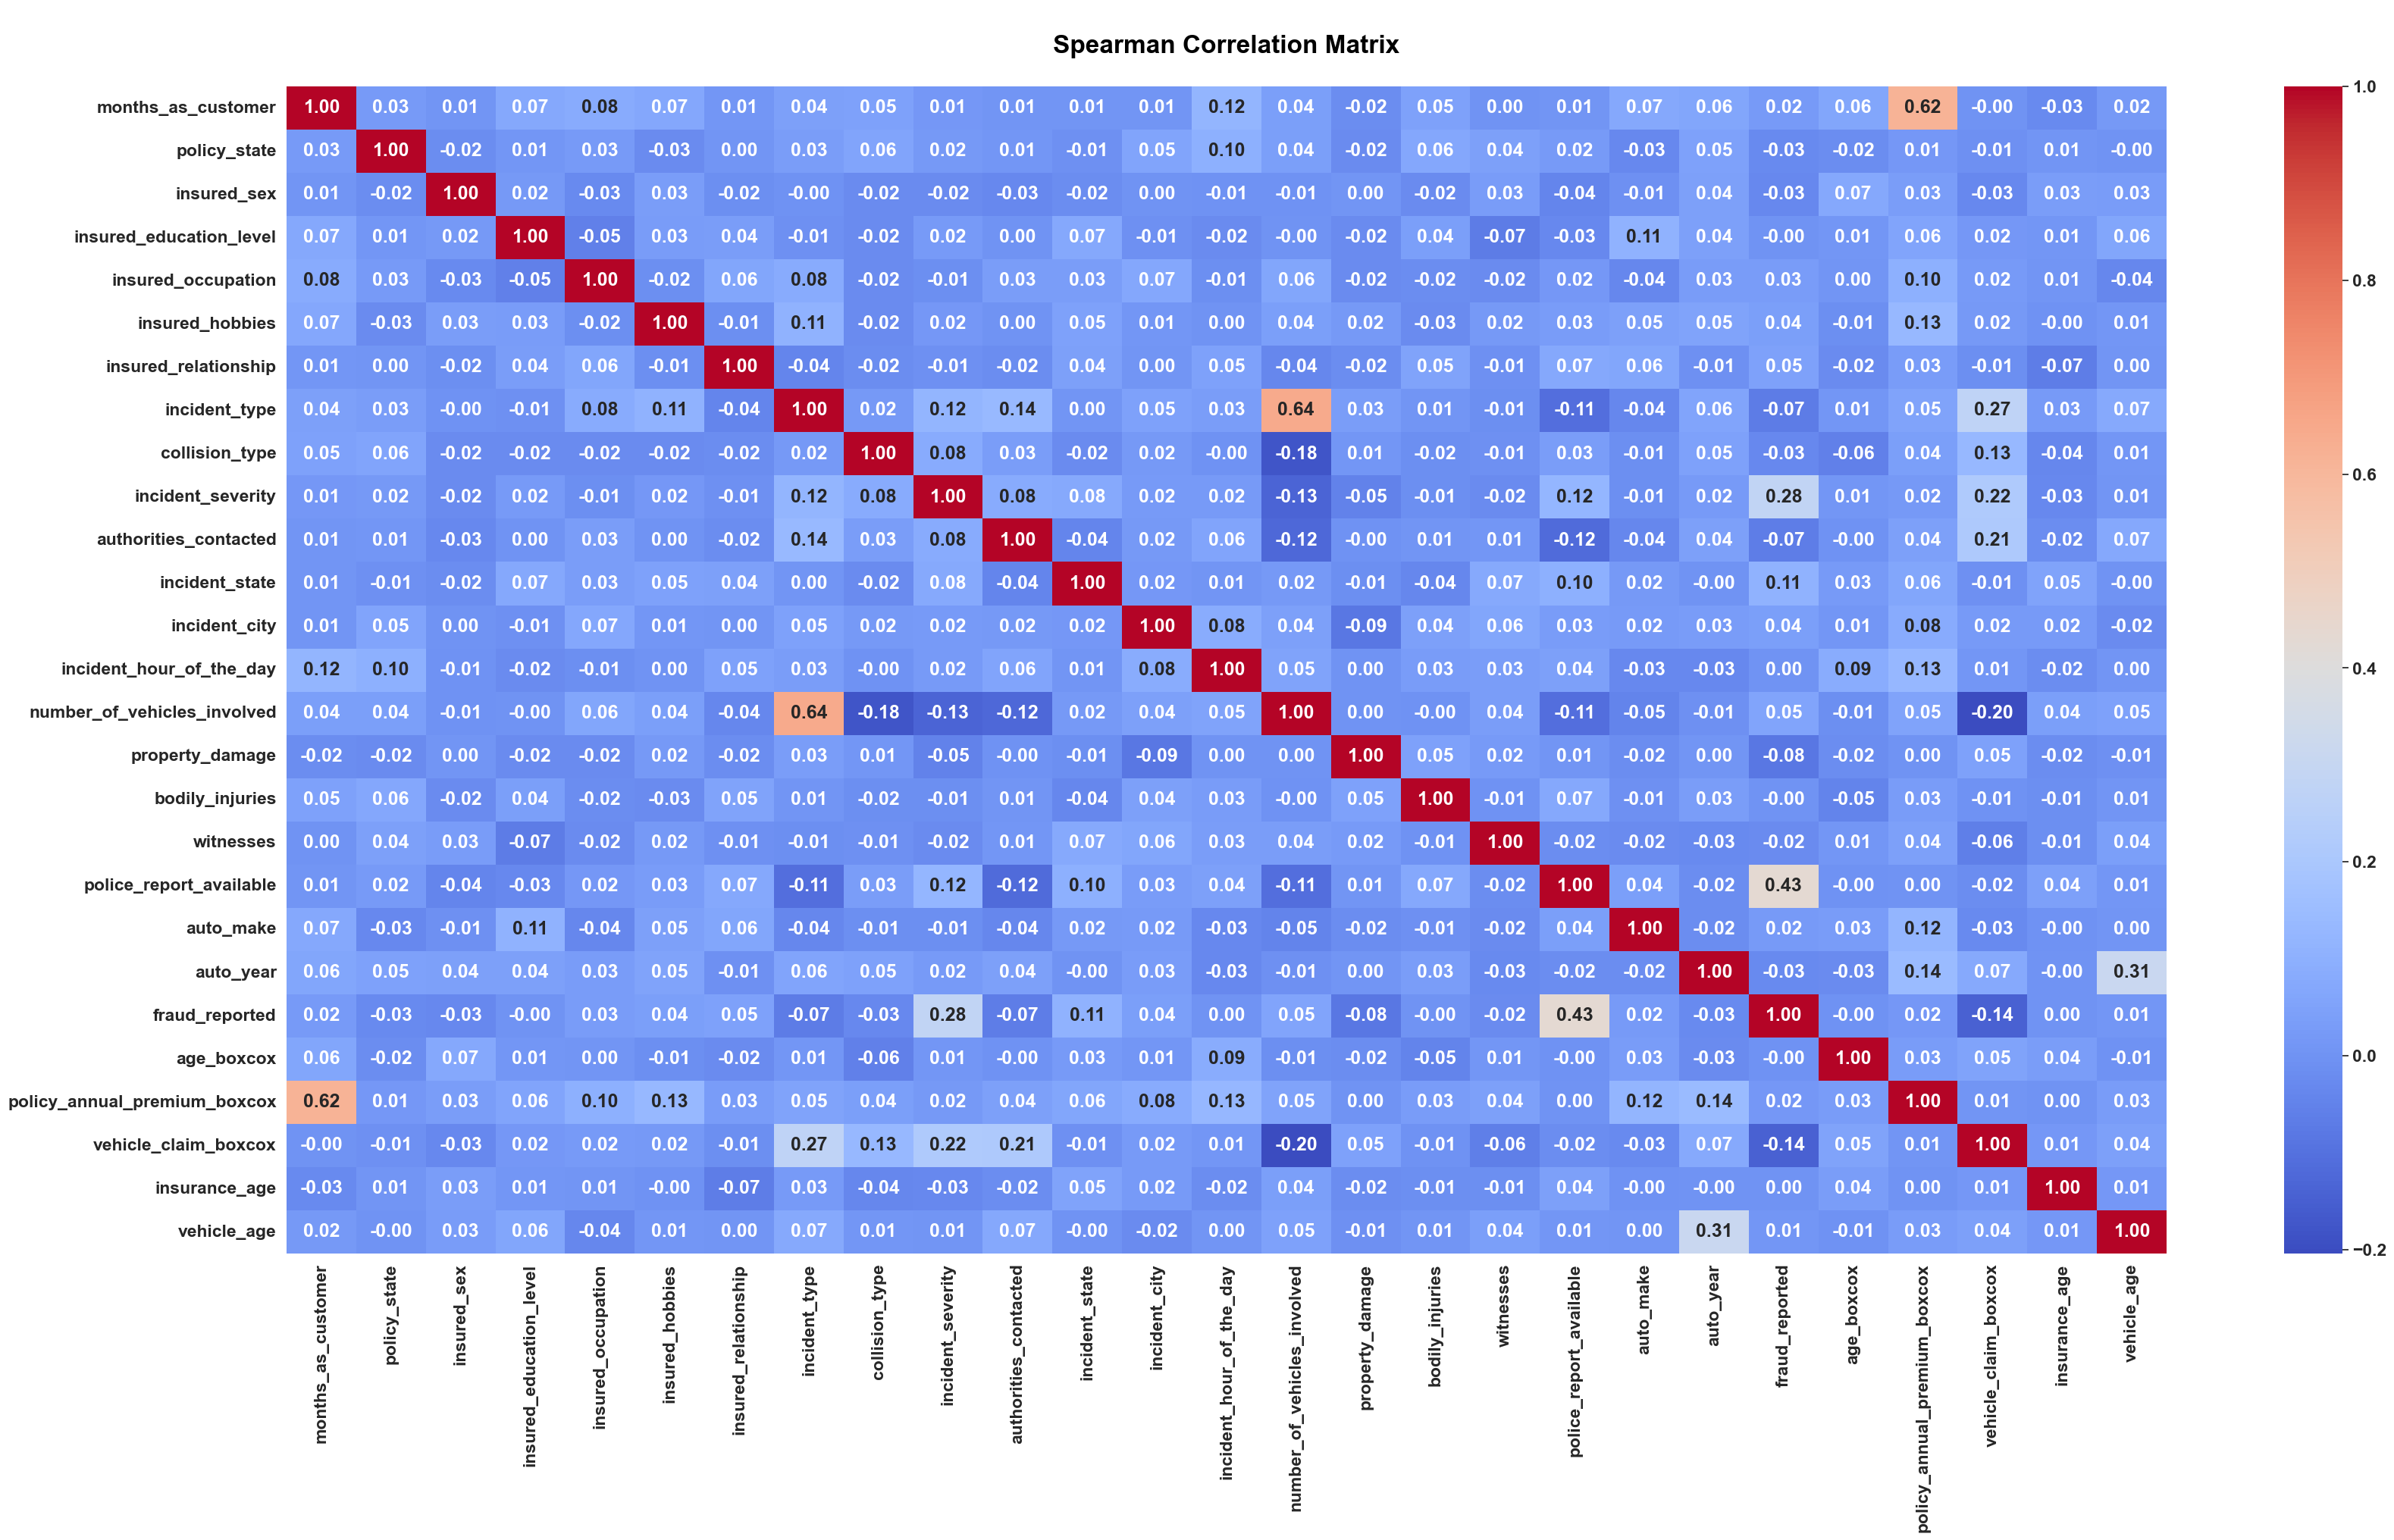

In [121]:
plt.figure(figsize=(40,20))
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1.5, color_codes=True, rc=None)
# continuous.extend(['policy_annual_premium_boxcox','insured_sex','property_damage','police_report_available','fraud_reported'])
cor_col = x 
correlation_matrix = cor_col.corr(method='spearman')
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('\nSpearman Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

plt.show()
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)


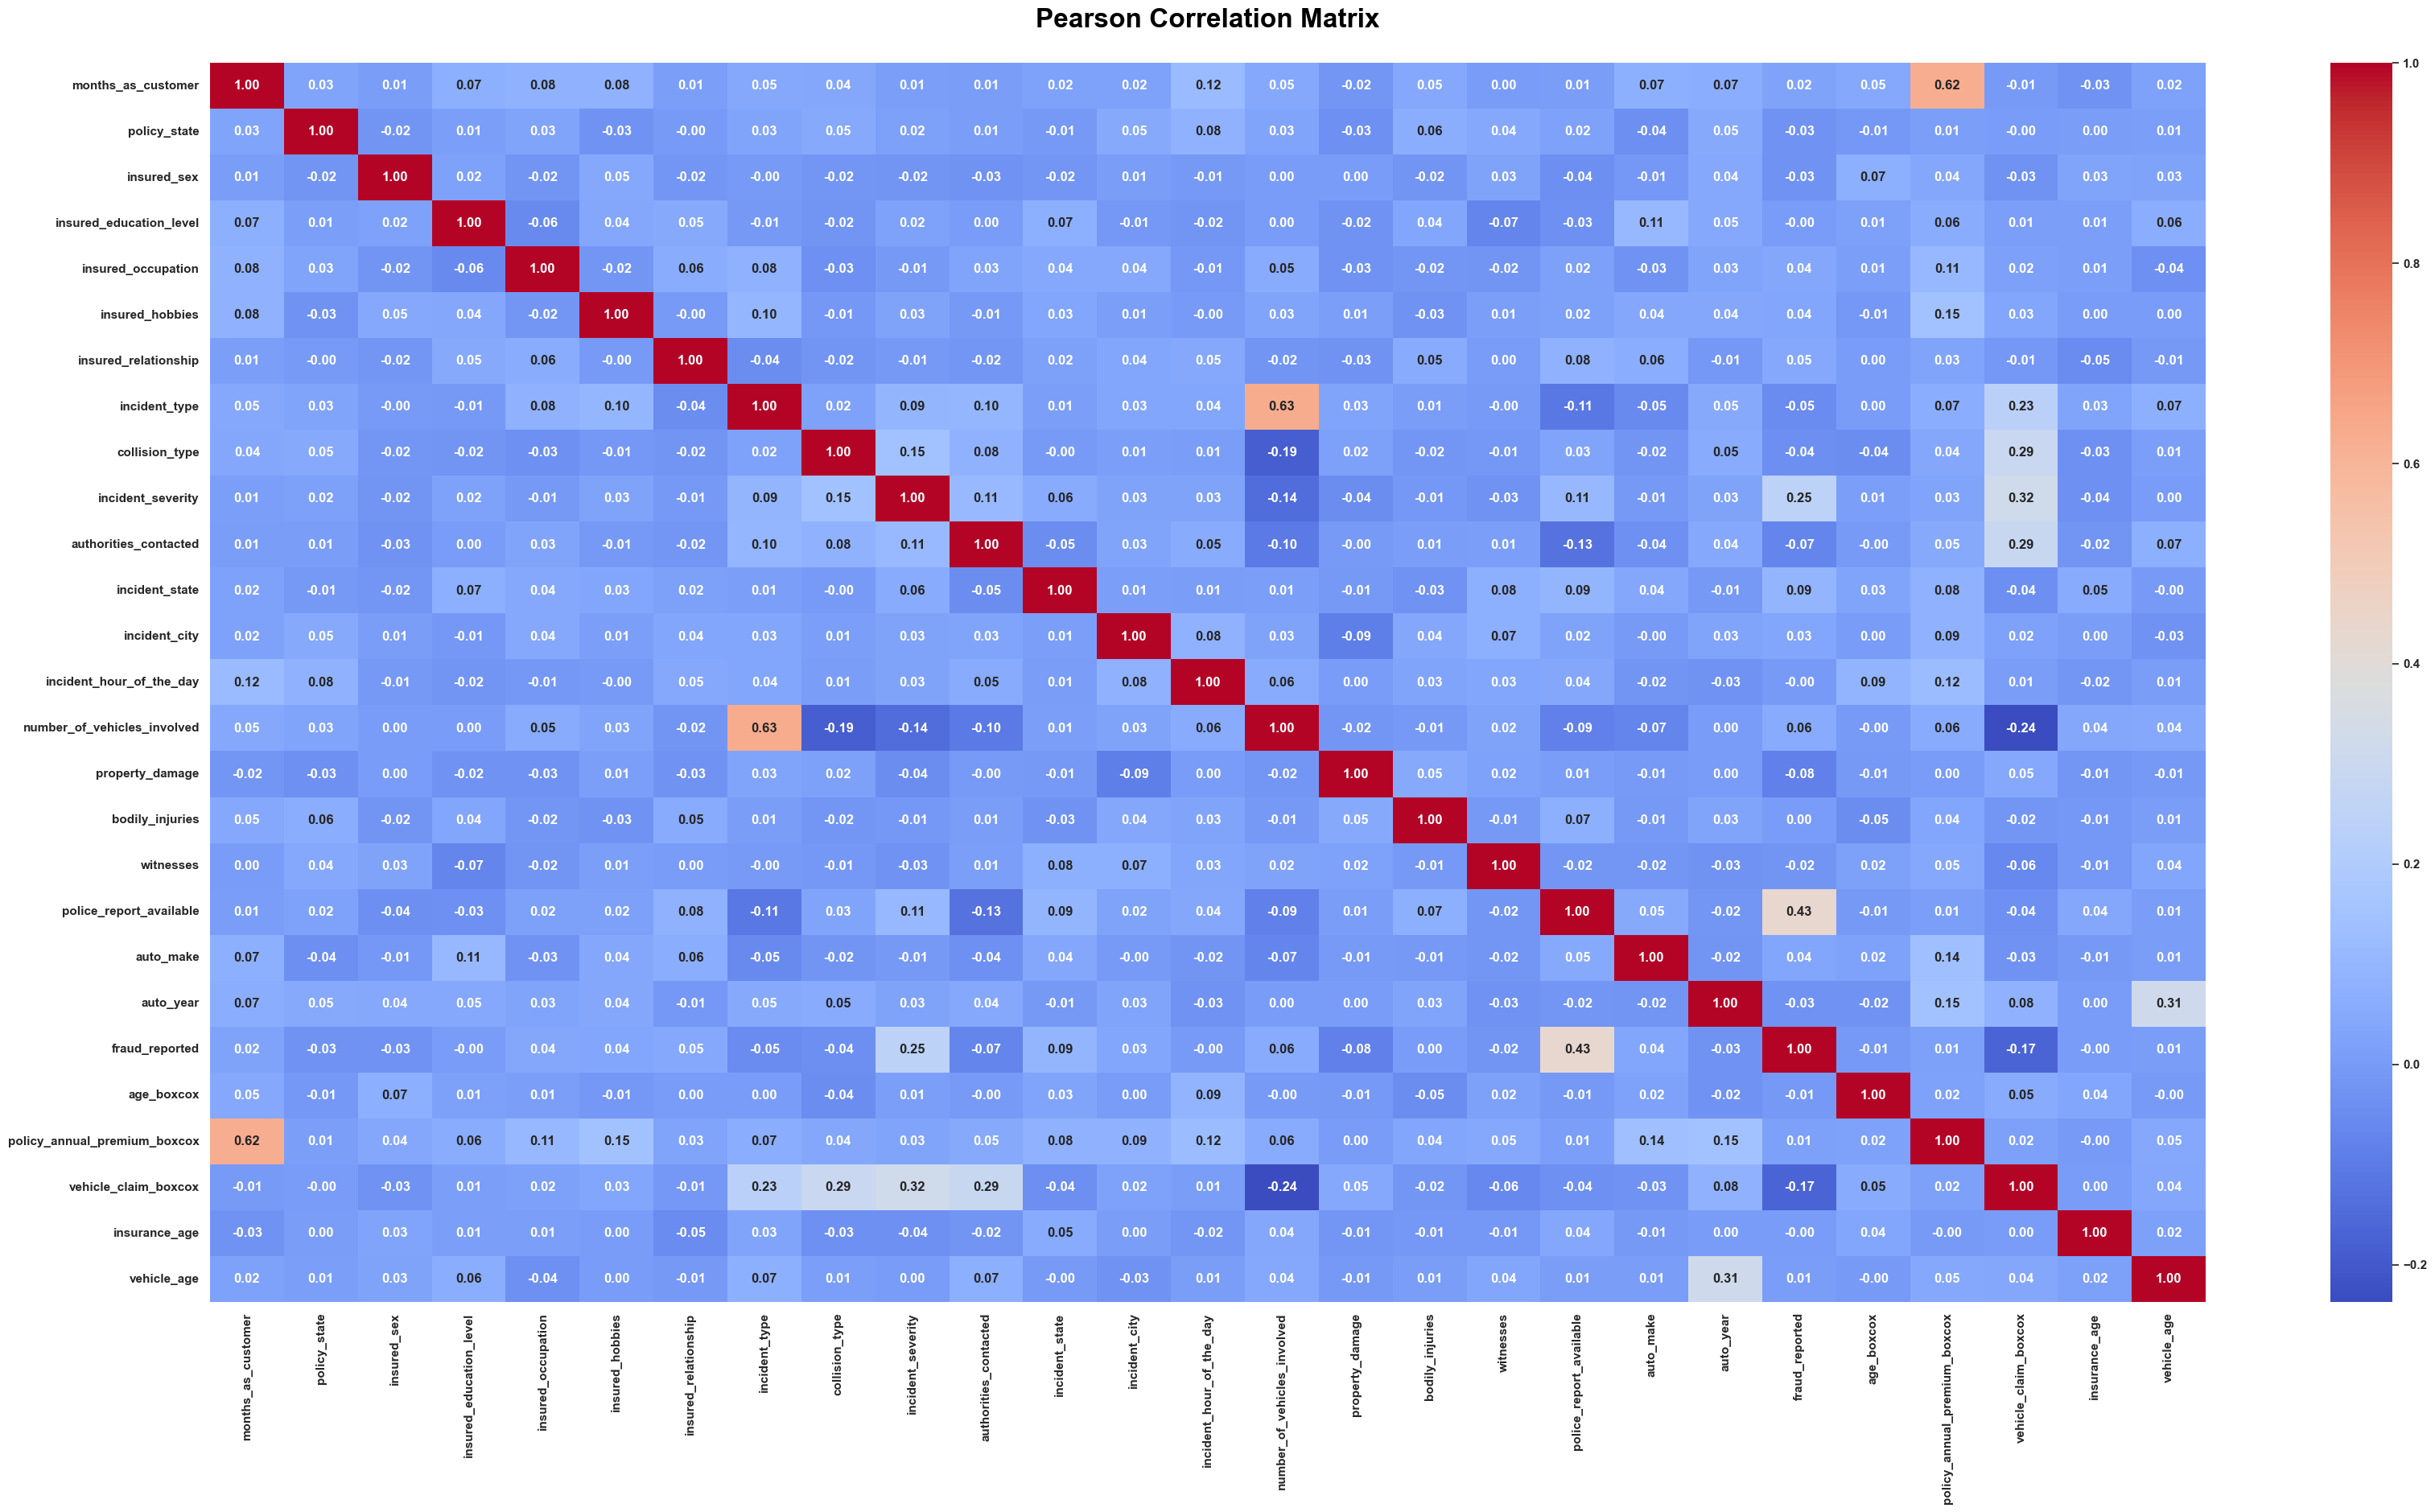

In [122]:
plt.figure(figsize=(40,20))
correlation_matrix = cor_col.corr(method='pearson')
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('Pearson Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

plt.show()
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)


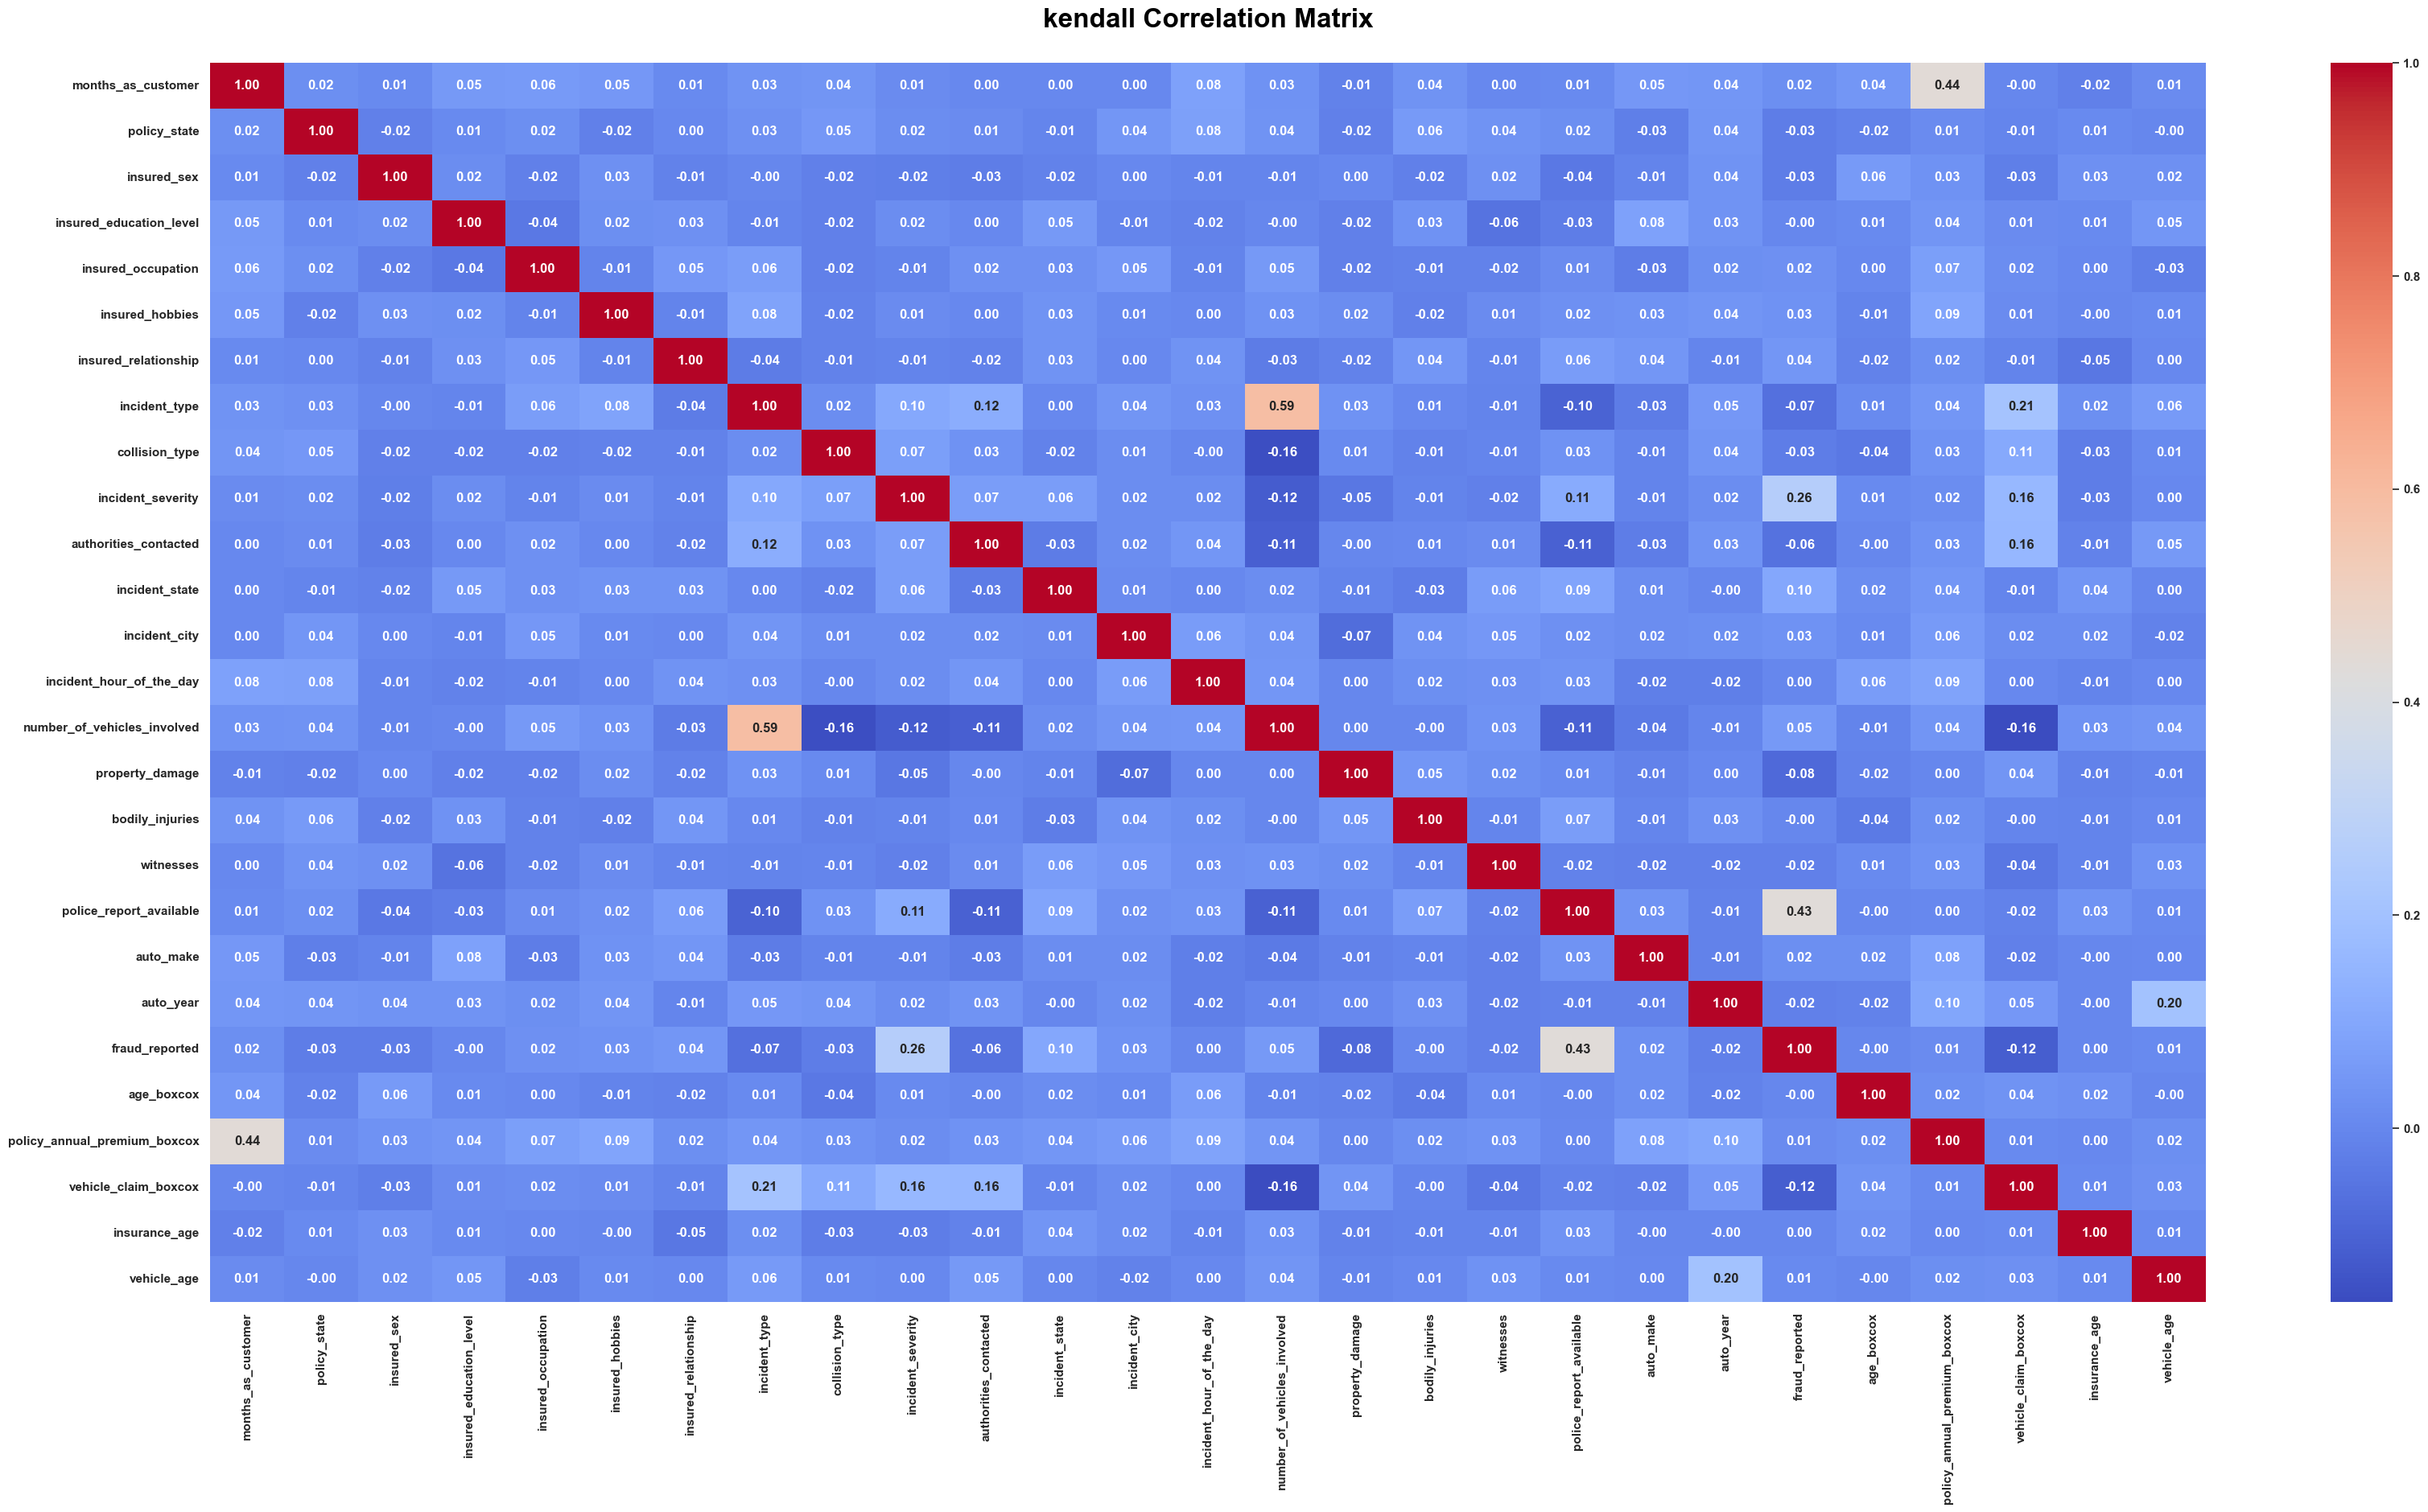

In [123]:
plt.figure(figsize=(40,20))
correlation_matrix = cor_col.corr(method='kendall')
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('kendall Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

plt.show()
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)


In [124]:
df.sample(1)

months_as_customer policy_bind_date  policy_state  policy_deductable  \
354                   8       1999-04-07     1259.0123               2000   

     insured_sex  insured_education_level  insured_occupation  \
354    1250.8982                        7           1236.4053   

     insured_hobbies  insured_relationship incident_date  incident_type  \
354        1274.0494             1274.4199    2015-02-06      1246.2443   

     collision_type  incident_severity  authorities_contacted  incident_state  \
354       1250.1644                  3              1268.2596       1257.3898   

     incident_city  incident_hour_of_the_day  number_of_vehicles_involved  \
354      1253.8180                         6                            3   

     property_damage  bodily_injuries  witnesses  police_report_available  \
354        1259.9850                1          1                1263.8948   

     auto_make  auto_year  fraud_reported  age_boxcox  \
354  1282.6163         19       1261.9112      3.7413   

     policy_annual_premium_boxcox  total_claim_amount_boxcox  \
354                      968.5060                141233.5164   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  \
354                  0                    0           127784.3925   

     insurance_age  vehicle_age  
354             16           20

In [125]:
Linear_regressor = LinearRegression()
evaluate_model(Linear_regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


LinearRegression

Training Time: 0.01 seconds

Coefficients -  [-1.66721109e+00  8.07552244e+01 -6.69614271e+02  4.71074200e+01
 -2.59921997e+03 -4.70931613e+02  2.71755133e+02  1.20845454e+00
  5.47668249e+02 -4.72402122e+02 -1.04701689e+02 -3.48006002e+02
 -3.71564362e+02 -2.69183780e+02  1.71241946e+02 -3.92664993e+02
  9.53593349e+02 -2.89752544e+02  1.40350902e+03  2.27722160e+02
 -1.73099848e+02  2.06465874e+01  6.26717796e+02  1.49572980e+02
 -4.04512863e+02  5.84665142e+02  5.05439356e+02]
Test Mean Squared Error  -- 124767460.5639
Train Mean Squared Error  -- 117881427.0607

Test R2 Score  -- 0.9624
Train R2 Score  -- 0.9633

Test Mean Absolute Error  -- 8235.1089
Train Mean Absolute Error  -- 8005.2163

Test Median Absolute Error  -- 5655.4251
Train Median Absolute Error  -- 5499.4723

Test Explained Variance Score  -- 0.9625
Train Explained Variance Score  -- 0.9633

Test Max Error  -- 37186.4239
Train Max Error  -- 38077.3034

Test Root Mean Squared Error  -- 11169.9356
Tr

In [126]:
feature_importances = Linear_regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [127]:
Ridge_regressor = Ridge(random_state=42)
evaluate_model(Ridge_regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


Ridge

Training Time: 0.01 seconds

Test Mean Squared Error  -- 124717626.4772
Train Mean Squared Error  -- 117881571.5514

Test R2 Score  -- 0.9624
Train R2 Score  -- 0.9633

Test Mean Absolute Error  -- 8231.3545
Train Mean Absolute Error  -- 8004.6813

Test Median Absolute Error  -- 5654.1052
Train Median Absolute Error  -- 5498.4525

Test Explained Variance Score  -- 0.9625
Train Explained Variance Score  -- 0.9633

Test Max Error  -- 37174.5937
Train Max Error  -- 38071.7814

Test Root Mean Squared Error  -- 11167.7046
Train Root Mean Squared Error  -- 10857.3280

--------------------------------------------------


In [128]:
Lasso_regressor = Lasso(random_state=42)
evaluate_model(Lasso_regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


Lasso

Training Time: 0.01 seconds

Test Mean Squared Error  -- 124731824.8518
Train Mean Squared Error  -- 117881468.1945

Test R2 Score  -- 0.9624
Train R2 Score  -- 0.9633

Test Mean Absolute Error  -- 8232.7300
Train Mean Absolute Error  -- 8004.7266

Test Median Absolute Error  -- 5654.3222
Train Median Absolute Error  -- 5494.8523

Test Explained Variance Score  -- 0.9625
Train Explained Variance Score  -- 0.9633

Test Max Error  -- 37174.1780
Train Max Error  -- 38070.9581

Test Root Mean Squared Error  -- 11168.3403
Train Root Mean Squared Error  -- 10857.3233

--------------------------------------------------


In [130]:
DT_Regressor = DecisionTreeRegressor(random_state=42)
evaluate_model(DT_Regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


DecisionTreeRegressor

Training Time: 0.01 seconds

Test Mean Squared Error  -- 233891712.7583
Train Mean Squared Error  -- 0.0000

Test R2 Score  -- 0.9295
Train R2 Score  -- 1.0000

Test Mean Absolute Error  -- 10960.1235
Train Mean Absolute Error  -- 0.0000

Test Median Absolute Error  -- 8325.9926
Train Median Absolute Error  -- 0.0000

Test Explained Variance Score  -- 0.9295
Train Explained Variance Score  -- 1.0000

Test Max Error  -- 58266.5036
Train Max Error  -- 0.0000

Test Root Mean Squared Error  -- 15293.5187
Train Root Mean Squared Error  -- 0.0000

--------------------------------------------------


                         Feature  Importance
7                  incident_type      0.9660
25                 insurance_age      0.0033
8                 collision_type      0.0027
10         authorities_contacted      0.0025
16               bodily_injuries      0.0025
0             months_as_customer      0.0025
22                    age_boxcox      0.0025
11                incident_state      0.0022
9              incident_severity      0.0016
14   number_of_vehicles_involved      0.0015
17                     witnesses      0.0014
3        insured_education_level      0.0014
15               property_damage      0.0012
5                insured_hobbies      0.0011
23  policy_annual_premium_boxcox      0.0011
1                   policy_state      0.0010
12                 incident_city      0.0010
20                     auto_year      0.0010
21                fraud_reported      0.0008
19                     auto_make      0.0006
24          vehicle_claim_boxcox      0.0005
6         

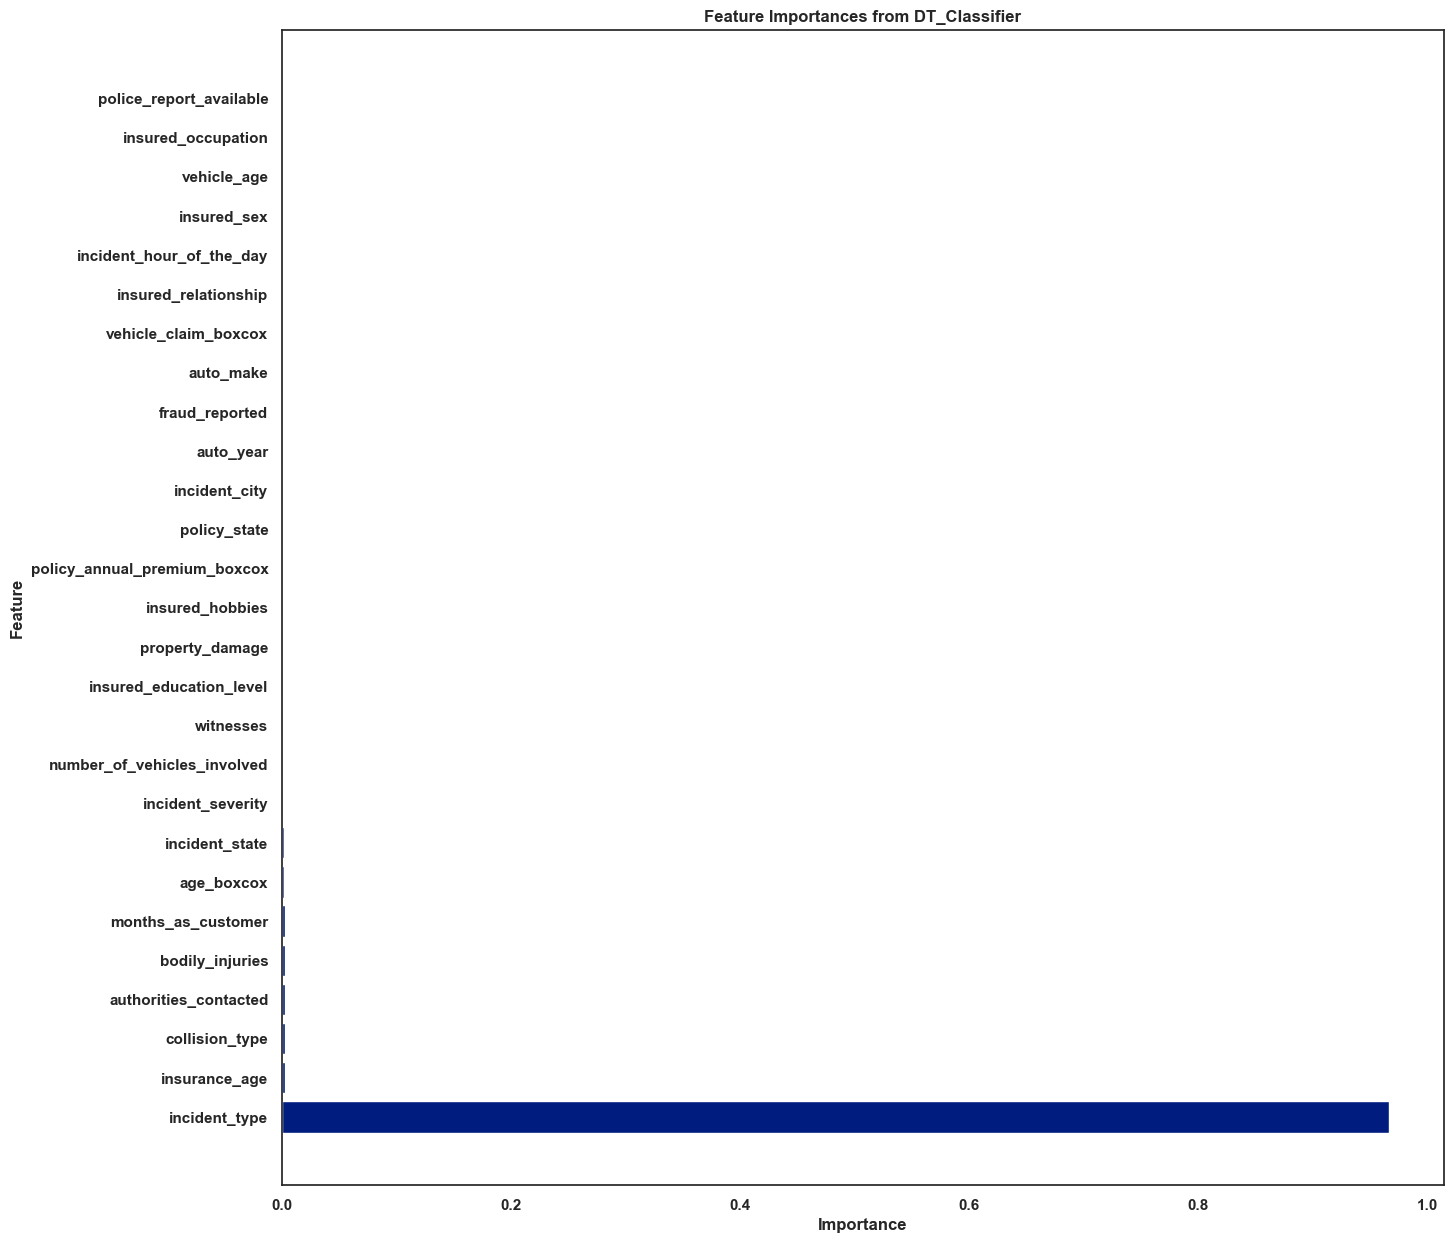

In [131]:
feature_importances = DT_Regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

In [132]:
RF_Regressor = RandomForestRegressor(n_estimators=10,random_state=42)
evaluate_model(RF_Regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


RandomForestRegressor

Training Time: 0.07 seconds

Test Mean Squared Error  -- 140512053.8100
Train Mean Squared Error  -- 25455558.9244

Test R2 Score  -- 0.9576
Train R2 Score  -- 0.9921

Test Mean Absolute Error  -- 8453.0859
Train Mean Absolute Error  -- 3548.0320

Test Median Absolute Error  -- 5920.2212
Train Median Absolute Error  -- 2413.9074

Test Explained Variance Score  -- 0.9577
Train Explained Variance Score  -- 0.9921

Test Max Error  -- 41453.7738
Train Max Error  -- 24186.8202

Test Root Mean Squared Error  -- 11853.7780
Train Root Mean Squared Error  -- 5045.3502

--------------------------------------------------


                         Feature  Importance
7                  incident_type      0.9666
8                 collision_type      0.0030
16               bodily_injuries      0.0029
10         authorities_contacted      0.0024
0             months_as_customer      0.0024
3        insured_education_level      0.0023
15               property_damage      0.0021
9              incident_severity      0.0020
22                    age_boxcox      0.0019
11                incident_state      0.0016
12                 incident_city      0.0016
17                     witnesses      0.0014
25                 insurance_age      0.0014
21                fraud_reported      0.0012
1                   policy_state      0.0010
20                     auto_year      0.0010
19                     auto_make      0.0009
13      incident_hour_of_the_day      0.0007
6           insured_relationship      0.0007
2                    insured_sex      0.0007
5                insured_hobbies      0.0007
14   numbe

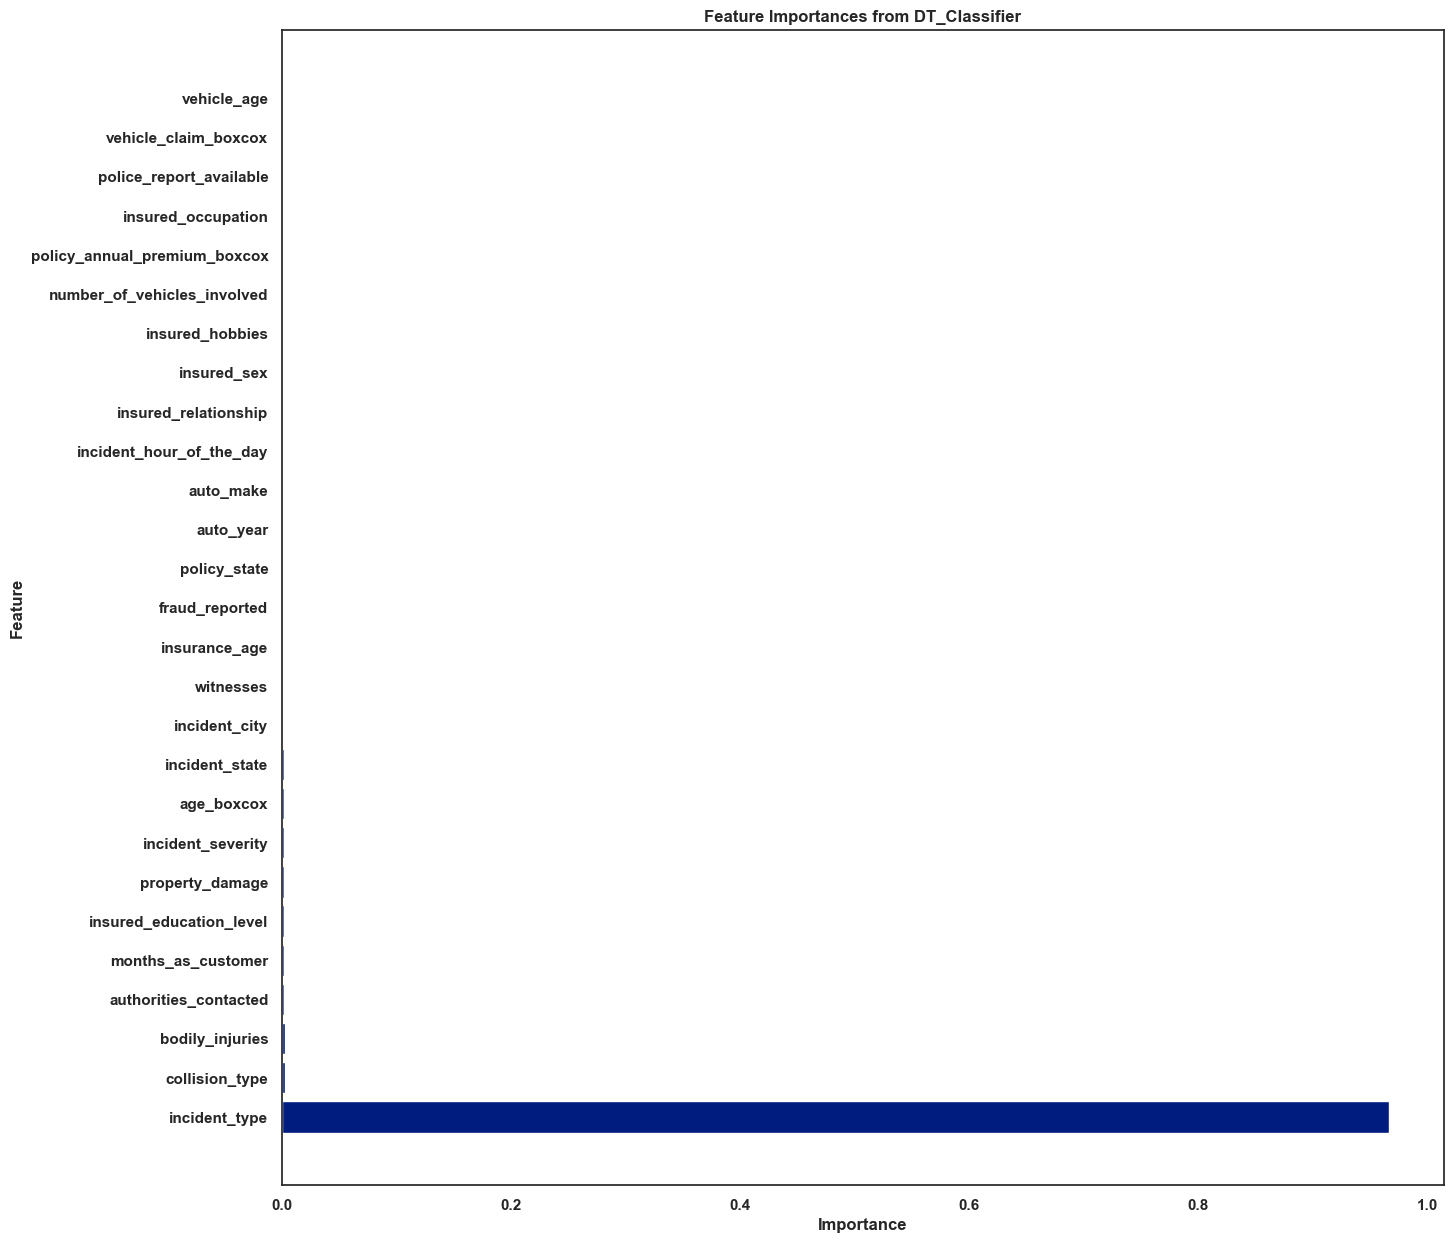

In [133]:
feature_importances = RF_Regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

In [134]:
ADA_Regressor = AdaBoostRegressor(random_state=42)
evaluate_model(ADA_Regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


AdaBoostRegressor

Training Time: 0.15 seconds

Test Mean Squared Error  -- 133798311.9876
Train Mean Squared Error  -- 106077358.0118

Test R2 Score  -- 0.9596
Train R2 Score  -- 0.9670

Test Mean Absolute Error  -- 8600.3424
Train Mean Absolute Error  -- 8131.1205

Test Median Absolute Error  -- 6117.8013
Train Median Absolute Error  -- 6481.8939

Test Explained Variance Score  -- 0.9609
Train Explained Variance Score  -- 0.9678

Test Max Error  -- 35066.4900
Train Max Error  -- 23324.8092

Test Root Mean Squared Error  -- 11567.1220
Train Root Mean Squared Error  -- 10299.3863

--------------------------------------------------


                         Feature  Importance
7                  incident_type      0.8964
22                    age_boxcox      0.0141
10         authorities_contacted      0.0136
12                 incident_city      0.0115
25                 insurance_age      0.0089
9              incident_severity      0.0086
5                insured_hobbies      0.0076
23  policy_annual_premium_boxcox      0.0062
15               property_damage      0.0056
3        insured_education_level      0.0048
8                 collision_type      0.0044
11                incident_state      0.0030
16               bodily_injuries      0.0029
13      incident_hour_of_the_day      0.0026
17                     witnesses      0.0022
1                   policy_state      0.0020
18       police_report_available      0.0014
4             insured_occupation      0.0012
2                    insured_sex      0.0012
0             months_as_customer      0.0006
20                     auto_year      0.0006
14   numbe

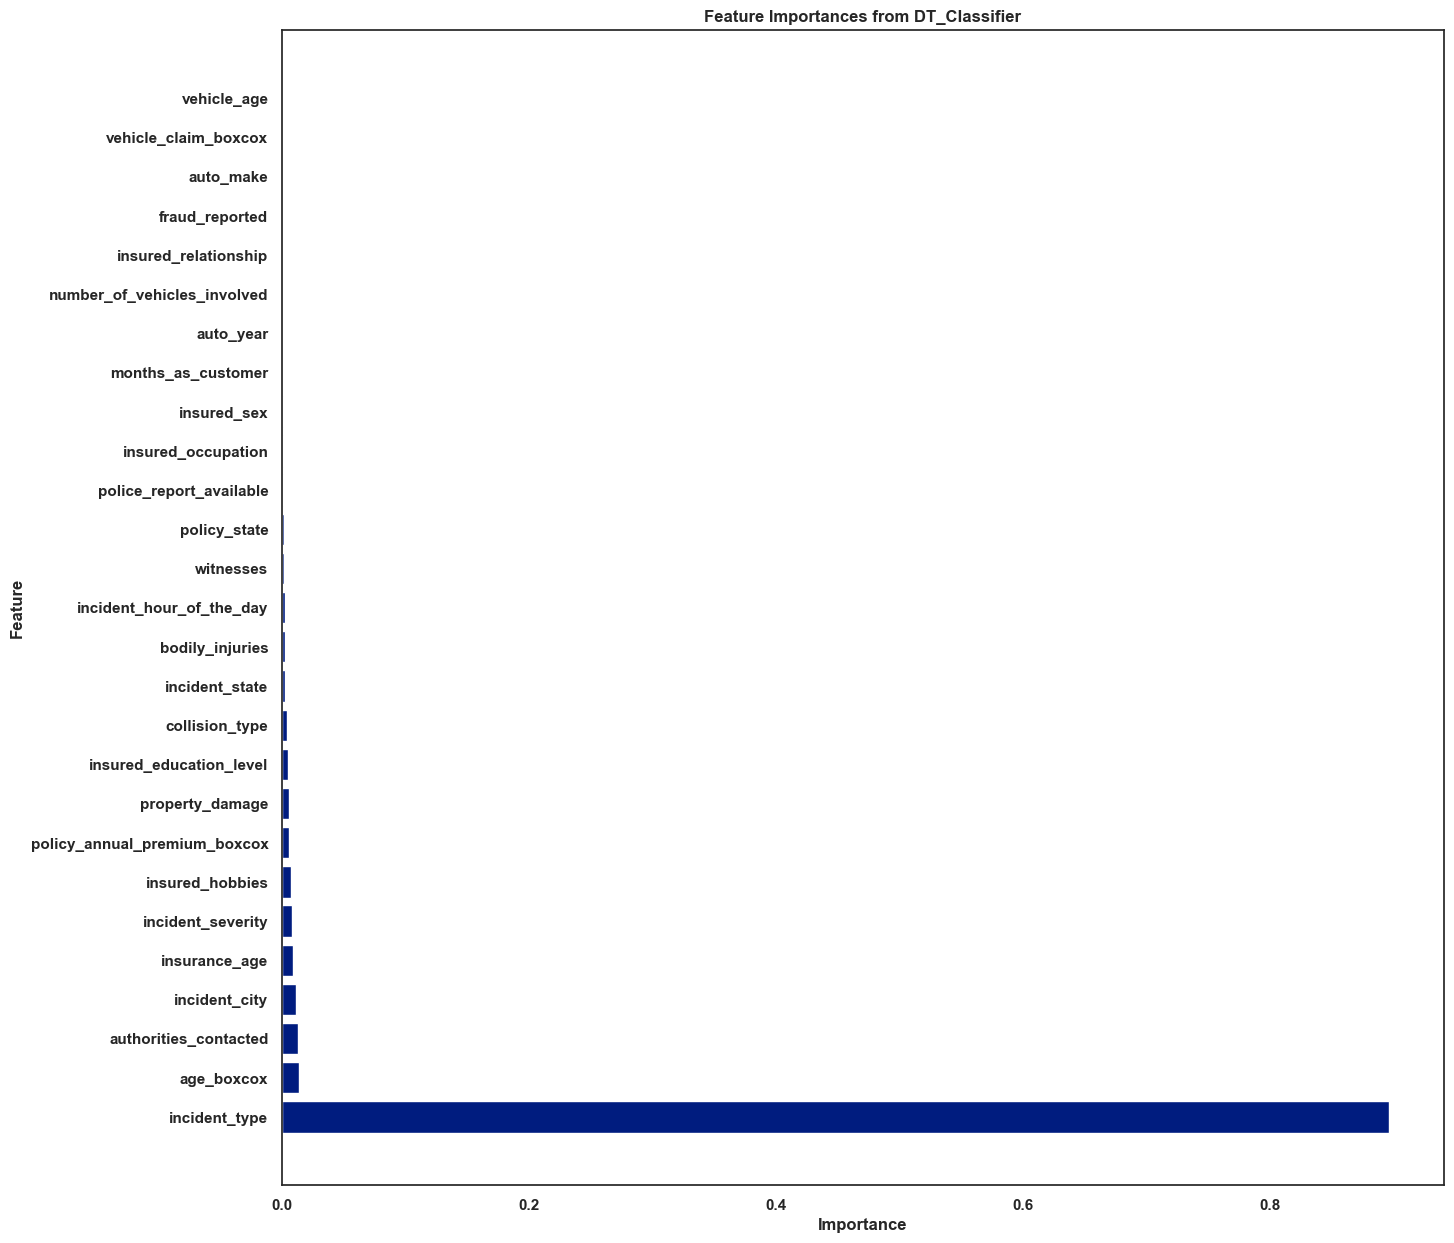

In [135]:
feature_importances = ADA_Regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

In [90]:
x.sample(1)

months_as_customer  policy_state  insured_sex  insured_education_level  \
362                 284     1259.0123    1270.4027                        6   

     insured_occupation  insured_hobbies  insured_relationship  incident_type  \
362           1262.8020        1294.0602             1274.4199      1237.0584   

     collision_type  incident_severity  authorities_contacted  incident_state  \
362       1252.4021                  1              1258.5390       1296.9199   

     incident_city  incident_hour_of_the_day  number_of_vehicles_involved  \
362      1240.9716                        20                            4   

     property_damage  bodily_injuries  witnesses  police_report_available  \
362        1259.9850                1          2                1257.6687   

     auto_make  auto_year  fraud_reported  age_boxcox  \
362  1323.3976          9       1261.9112      3.8769   

     policy_annual_premium_boxcox  insurance_age  vehicle_age  
362                     1345.7806             11           16

In [136]:
fea_imp = ['witnesses','insured_sex','police_report_available','collision_type','incident_type','months_as_customer','incident_severity','property_damage',]

GB_Regressor = GradientBoostingRegressor(random_state=42)
evaluate_model(GB_Regressor, x_train_scaled_df[fea_imp], y_train, x_test_scaled_df[fea_imp], y_test)


GradientBoostingRegressor

Training Time: 0.11 seconds

Test Mean Squared Error  -- 1134993151.2586
Train Mean Squared Error  -- 817050444.5993

Test R2 Score  -- 0.6577
Train R2 Score  -- 0.7460

Test Mean Absolute Error  -- 25479.5542
Train Mean Absolute Error  -- 22042.2333

Test Median Absolute Error  -- 19068.6012
Train Median Absolute Error  -- 17009.7069

Test Explained Variance Score  -- 0.6632
Train Explained Variance Score  -- 0.7460

Test Max Error  -- 96774.8536
Train Max Error  -- 100265.4362

Test Root Mean Squared Error  -- 33689.6594
Train Root Mean Squared Error  -- 28584.0943

--------------------------------------------------


In [137]:
feature_importances = GB_Regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

ValueError: All arrays must be of the same length

In [83]:
# xg_x_train = x_train_scaled_df[feature_columns].values
# xg_x_test = x_test_scaled_df[feature_columns].values

XGB_Regressor = xg.XGBRegressor(random_state=42)
evaluate_model(XGB_Regressor, x_train_scaled_df.values, y_train, x_test_scaled_df.values, y_test)


XGBRegressor

Training Time: 0.17 seconds

Test Mean Squared Error  -- 1288374017.3358
Train Mean Squared Error  -- 25404.5410

Test R2 Score  -- 0.6114
Train R2 Score  -- 1.0000

Test Mean Absolute Error  -- 26830.0516
Train Mean Absolute Error  -- 106.5636

Test Median Absolute Error  -- 18973.6474
Train Median Absolute Error  -- 69.9340

Test Explained Variance Score  -- 0.6139
Train Explained Variance Score  -- 1.0000

Test Max Error  -- 117445.1427
Train Max Error  -- 855.7659

Test Root Mean Squared Error  -- 35893.9273
Train Root Mean Squared Error  -- 159.3880

--------------------------------------------------


In [84]:
ET_Regressor = ExtraTreesRegressor(random_state=42)
evaluate_model(ET_Regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)



ExtraTreesRegressor

Training Time: 0.37 seconds

Test Mean Squared Error  -- 1085890294.8781
Train Mean Squared Error  -- 0.0000

Test R2 Score  -- 0.6725
Train R2 Score  -- 1.0000

Test Mean Absolute Error  -- 23939.0387
Train Mean Absolute Error  -- 0.0000

Test Median Absolute Error  -- 17139.1531
Train Median Absolute Error  -- 0.0000

Test Explained Variance Score  -- 0.6774
Train Explained Variance Score  -- 1.0000

Test Max Error  -- 98120.3321
Train Max Error  -- 0.0000

Test Root Mean Squared Error  -- 32952.8496
Train Root Mean Squared Error  -- 0.0000

--------------------------------------------------


In [206]:
dd = ['vehicle_claim_boxcox',
 'Cluster',
 'fraud_reported',
 'number_of_vehicles_involved',
 'incident_hour_of_the_day']

In [85]:
params = {'n_neighbors' : list(range(1,22))}

KNN_grid_model = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params, cv=3, scoring='neg_mean_squared_error',verbose=3, n_jobs=1,error_score='raise')

KNN_grid_model.fit(x_train_scaled_df,y_train)

print(KNN_grid_model.best_params_)


Fitting 3 folds for each of 21 candidates, totalling 63 fits
[CV 1/3] END ...........n_neighbors=1;, score=-5784070154.161 total time=   0.1s
[CV 2/3] END ...........n_neighbors=1;, score=-5462344396.949 total time=   0.0s
[CV 3/3] END ...........n_neighbors=1;, score=-5791649773.131 total time=   0.0s
[CV 1/3] END ...........n_neighbors=2;, score=-4324892502.469 total time=   0.0s
[CV 2/3] END ...........n_neighbors=2;, score=-4151370970.776 total time=   0.0s
[CV 3/3] END ...........n_neighbors=2;, score=-4600729625.300 total time=   0.0s
[CV 1/3] END ...........n_neighbors=3;, score=-3951127221.617 total time=   0.0s
[CV 2/3] END ...........n_neighbors=3;, score=-4024889581.347 total time=   0.0s
[CV 3/3] END ...........n_neighbors=3;, score=-4178695579.350 total time=   0.0s
[CV 1/3] END ...........n_neighbors=4;, score=-3802320435.232 total time=   0.0s
[CV 2/3] END ...........n_neighbors=4;, score=-3953985460.980 total time=   0.0s
[CV 3/3] END ...........n_neighbors=4;, score=-3

In [86]:
print(f"KNN Best Score - {KNN_grid_model.best_score_}\n\nKNN Best Params - {KNN_grid_model.best_params_}\n\nKNN Best Estimater - {KNN_grid_model.best_estimator_} \n\nKNN Best Index - {KNN_grid_model.best_index_} ")

KNN Best Score - -3399131614.508232

KNN Best Params - {'n_neighbors': 19}

KNN Best Estimater - KNeighborsRegressor(n_neighbors=19) 

KNN Best Index - 18 


In [87]:
KNN_Regressor = KNeighborsRegressor(n_neighbors=19)
evaluate_model(KNN_Regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)



KNeighborsRegressor

Training Time: 0.01 seconds

Test Mean Squared Error  -- 3470170521.6930
Train Mean Squared Error  -- 3047606070.6391

Test R2 Score  -- -0.0466
Train R2 Score  -- 0.0525

Test Mean Absolute Error  -- 46608.9820
Train Mean Absolute Error  -- 43752.6095

Test Median Absolute Error  -- 33761.9462
Train Median Absolute Error  -- 34489.9583

Test Explained Variance Score  -- -0.0359
Train Explained Variance Score  -- 0.0537

Test Max Error  -- 137061.3769
Train Max Error  -- 139099.2414

Test Root Mean Squared Error  -- 58908.1533
Train Root Mean Squared Error  -- 55205.1272

--------------------------------------------------
